# Import library

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Dropout, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import initializers
from tensorflow.keras.layers import add, concatenate
%matplotlib inline  
import warnings
warnings.filterwarnings('ignore')
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy.sparse import csr_matrix
import tensorflow as tf
from tensorflow.keras.models import model_from_json
from sklearn import preprocessing
from keras.utils.vis_utils import plot_model

# Data Preprocessing

In [ ]:
ratings = pd.read_csv('ml1m_ratings.csv',sep=',', encoding='latin-1', 
                      usecols=['user_emb_id', 'movie_emb_id', 'rating', 'timestamp'])

#plus 1 to get the size since we index starting with 0
num_users = ratings['user_emb_id'].unique().max() + 1
num_movies = ratings['movie_emb_id'].unique().max() + 1
ratings.head(10)

,user_emb_id,movie_emb_id,rating,timestamp
0,0,1192,5,978300760
1,0,660,3,978302109
2,0,913,3,978301968
3,0,3407,4,978300275
4,0,2354,5,978824291
5,0,1196,3,978302268
6,0,1286,5,978302039
7,0,2803,5,978300719
8,0,593,4,978302268
9,0,918,4,978301368


In [ ]:
ratings = ratings.dropna()

In [ ]:
ratings.shape

(1000209, 4)

In [ ]:
#Split 90% train and 10% test 
train_df, test_df = train_test_split(ratings,stratify=ratings['user_emb_id'],test_size=0.1,random_state=18133047)  

In [ ]:
train_df.head(10)

,user_emb_id,movie_emb_id,rating,timestamp
591079,3605,3106,4,966612757
323095,1915,2458,3,974689866
211188,1284,2709,5,974794389
148166,954,2063,1,975133820
634057,3824,2182,4,965940400
2078,17,779,3,978153540
395964,2339,3528,4,974423252
225340,1361,3750,5,975206570
973088,5866,3202,5,957594407
122619,790,1386,5,982009185


In [ ]:
#Split validation 
train_df, validate_df = train_test_split(train_df,stratify=train_df['user_emb_id'],test_size=0.1,random_state=18133047)  

In [ ]:
def dataPreprocessor(rating_df, num_users, num_items, init_value=0, average=False):
    """
    This function sets default rating values for the model
        INPUT: 
            data: DataFrame columns=['userID', 'itemID', 'rating']
            num_row: int number of users
            num_col: int number of items
        OUTPUT:
            matrix: 2D numpy array. 
    """
    if average:
      matrix = np.full((num_users, num_items), 0.0)
      for (_, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID, itemID] = rating
      avergae = np.true_divide(matrix.sum(1), np.maximum((matrix!=0).sum(1), 1))
      inds = np.where(matrix == 0)
      matrix[inds] = np.take(avergae, inds[0])
      
    else:
      matrix = np.full((num_users, num_items), init_value)
      for (_, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID, itemID] = rating

    return matrix

In [ ]:
# create a user-item matrix with missing rating values from 1 to 5 and the average
users_items_matrix_train_zero = dataPreprocessor(train_df, num_users, num_movies, 0)
users_items_matrix_train_one = dataPreprocessor(train_df, num_users, num_movies, 1)
users_items_matrix_train_two = dataPreprocessor(train_df, num_users, num_movies, 2)
users_items_matrix_train_three = dataPreprocessor(train_df, num_users, num_movies, 3)
users_items_matrix_train_four = dataPreprocessor(train_df, num_users, num_movies, 4)
users_items_matrix_train_five = dataPreprocessor(train_df, num_users, num_movies, 5)
# On test and validation
users_items_matrix_validate = dataPreprocessor(validate_df, num_users, num_movies, 0)
users_items_matrix_test = dataPreprocessor(test_df, num_users, num_movies, 0)
# Average
users_items_matrix_train_average = dataPreprocessor(train_df, num_users, num_movies, average=True)

In [ ]:
users_items_matrix_train_zero

array([[5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
users_items_matrix_train_one

array([[5, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [ ]:
users_items_matrix_train_two

array([[5, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])

In [ ]:
users_items_matrix_train_three

array([[5, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]])

In [ ]:
users_items_matrix_train_four

array([[5, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       ...,
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4]])

In [ ]:
users_items_matrix_train_five

array([[5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       ...,
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5]])

In [ ]:
users_items_matrix_train_average

array([[5.        , 4.13953488, 4.13953488, ..., 4.13953488, 4.13953488,
        4.13953488],
       [3.70192308, 3.70192308, 3.70192308, ..., 3.70192308, 3.70192308,
        3.70192308],
       [3.90243902, 3.90243902, 3.90243902, ..., 3.90243902, 3.90243902,
        3.90243902],
       ...,
       [3.5625    , 3.5625    , 3.5625    , ..., 3.5625    , 3.5625    ,
        3.5625    ],
       [3.89      , 3.89      , 3.89      , ..., 3.89      , 3.89      ,
        3.89      ],
       [3.56884058, 3.56884058, 3.56884058, ..., 3.56884058, 3.56884058,
        3.56884058]])

#Function

In [ ]:
def show_error(history, skip):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(np.arange(skip, len(loss), 1), loss[skip:])
    plt.plot(np.arange(skip, len(loss), 1), val_loss[skip:])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [ ]:
def show_rmse(history, skip):
    rmse = history.history['masked_rmse_clip']
    val_rmse = history.history['val_masked_rmse_clip']
    plt.plot(np.arange(skip, len(rmse), 1), rmse[skip:])
    plt.plot(np.arange(skip, len(val_rmse), 1), val_rmse[skip:])
    plt.title('model train vs validation masked_rmse')
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [ ]:
def load_model(name):
  # load json and create model
  model_file = open('{}.json'.format(name), 'r')
  loaded_model_json = model_file.read()
  model_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # load weights into new model
  loaded_model.load_weights("{}.h5".format(name))
  print("Loaded model from disk")
  return loaded_model
  

In [ ]:
def save_model(name, model):
  # # serialize model to JSON
  model_json = model.to_json()
  with open("{}.json".format(name), "w") as json_file:
      json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights("{}.h5".format(name))
  print("Saved model to disk")

In [ ]:
def masked_se(y_true, y_pred):
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1)
        return masked_mse

In [ ]:
def masked_mse(y_true, y_pred):
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1)
        return masked_mse

In [ ]:
def masked_rmse(y_true, y_pred):
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

In [ ]:
def masked_rmse_clip(y_true, y_pred):
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        y_pred = K.clip(y_pred, 1, 5)
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

In [ ]:
def Deep_AE_recommend_topx(userid, system, movies, number):
    temp = system.loc[userid,:]
    query = temp.sort_values(ascending=False)
    moviesids = query[0:number].index
    return (movies[movies.movie_emb_id.isin(moviesids.astype(int).tolist())])

# AutoRec Model

In [ ]:
def AutoRec(X, reg, first_activation, last_activation):
    '''
    AutoRec
        INPUT: 
          X: #_user X #_item matrix
          reg: L2 regularization parameter
          first_activation: activation function for first dense layer
          last_activation: activation function for second dense layer
        OUTPUT:
          Keras model
    '''
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    x = Dense(500, activation=first_activation, name='LatentSpace', kernel_regularizer=regularizers.l2(reg))(x)
    output_layer = Dense(X.shape[1], activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(reg))(x)
    model = Model(input_layer, output_layer)

    return model

In [ ]:
def AutoRec_LReLU(X, reg):
    '''
    AutoRec
    LReLu is not implemented in to Dense 
    Need to have separate LeakyRelu layer 
    '''
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    x = Dense(500, name='LatentSpace', kernel_regularizer=regularizers.l2(reg))(x)
    x = LeakyReLU()(x)
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred',kernel_regularizer=regularizers.l2(reg))(x)
    model = Model(input_layer, output_layer)

    return model

## Build model with Sigmoid, Linear activation (Base model)

In [ ]:
AutoRec_Sigmoid_Linear = AutoRec(users_items_matrix_train_zero, 0.001, 'sigmoid', 'linear')

AutoRec_Sigmoid_Linear.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
 
AutoRec_Sigmoid_Linear.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 LatentSpace (Dense)         (None, 500)               1976500   
                                                                 
 UserScorePred (Dense)       (None, 3952)              1979952   
                                                                 
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_Autorec_Sigmoid_Linear = AutoRec_Sigmoid_Linear.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate.astype(float)])


Epoch 1/500
24/24 - 1s - loss: 14.4926 - masked_rmse_clip: 2.8945 - val_loss: 11.9448 - val_masked_rmse_clip: 2.8451 - 1s/epoch - 50ms/step
Epoch 2/500
24/24 - 0s - loss: 9.6170 - masked_rmse_clip: 2.6691 - val_loss: 7.2426 - val_masked_rmse_clip: 2.2976 - 424ms/epoch - 18ms/step
Epoch 3/500
24/24 - 0s - loss: 5.7112 - masked_rmse_clip: 1.9771 - val_loss: 4.3958 - val_masked_rmse_clip: 1.6120 - 425ms/epoch - 18ms/step
Epoch 4/500
24/24 - 0s - loss: 3.7190 - masked_rmse_clip: 1.4381 - val_loss: 3.2136 - val_masked_rmse_clip: 1.2513 - 401ms/epoch - 17ms/step
Epoch 5/500
24/24 - 0s - loss: 2.9553 - masked_rmse_clip: 1.1975 - val_loss: 2.7931 - val_masked_rmse_clip: 1.1212 - 431ms/epoch - 18ms/step
Epoch 6/500
24/24 - 0s - loss: 2.6726 - masked_rmse_clip: 1.1173 - val_loss: 2.6216 - val_masked_rmse_clip: 1.0822 - 423ms/epoch - 18ms/step
Epoch 7/500
24/24 - 0s - loss: 2.5363 - masked_rmse_clip: 1.0919 - val_loss: 2.5167 - val_masked_rmse_clip: 1.0683 - 412ms/epoch - 17ms/step
Epoch 8/500
24

In [ ]:
print(sorted(hist_Autorec_Sigmoid_Linear.history['val_masked_rmse_clip']))

[0.9138448238372803, 0.9140427112579346, 0.9141539335250854, 0.9142354130744934, 0.9142592549324036, 0.9142659902572632, 0.9142782092094421, 0.9144954681396484, 0.9145339131355286, 0.9146195650100708, 0.9146470427513123, 0.91466224193573, 0.9146975874900818, 0.9147219061851501, 0.9147897362709045, 0.9148049354553223, 0.9148126244544983, 0.9148246645927429, 0.9148496389389038, 0.9148857593536377, 0.914889931678772, 0.9148961901664734, 0.9149035811424255, 0.9149558544158936, 0.9150113463401794, 0.9150235652923584, 0.9150501489639282, 0.9150522351264954, 0.9150537848472595, 0.9150719046592712, 0.915117621421814, 0.915136456489563, 0.9151649475097656, 0.9151659607887268, 0.9151729941368103, 0.9151745438575745, 0.9151759147644043, 0.9151939749717712, 0.9152027368545532, 0.9152035117149353, 0.9152089357376099, 0.9152246713638306, 0.9152390360832214, 0.9152460694313049, 0.9152693152427673, 0.9152827262878418, 0.9153710603713989, 0.9153737425804138, 0.9153791666030884, 0.9153850674629211, 0.91

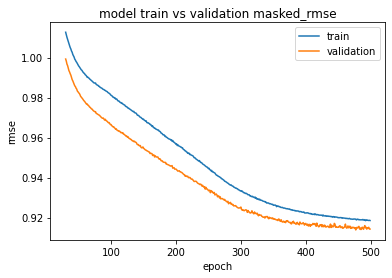

In [ ]:
show_rmse(hist_Autorec_Sigmoid_Linear, 30)

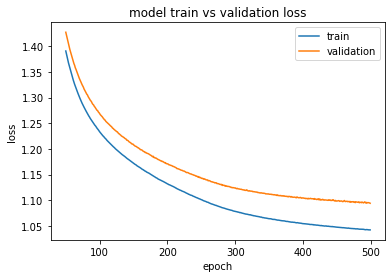

In [ ]:
show_error(hist_Autorec_Sigmoid_Linear, 50)

In [ ]:
test_result_Autorec_Sigmoid_Linear = AutoRec_Sigmoid_Linear.evaluate(users_items_matrix_train_zero, users_items_matrix_test.astype(float))

189/189 [==============================] - 1s 3ms/step - loss: 1.0833 - masked_rmse_clip: 0.9116


## Build model with Sigmoid, ELU activation

In [ ]:
AutoRec_Sigmoid_Elu = AutoRec(users_items_matrix_train_zero, 0.001, 'sigmoid', 'elu')

AutoRec_Sigmoid_Elu.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
 
AutoRec_Sigmoid_Elu.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 LatentSpace (Dense)         (None, 500)               1976500   
                                                                 
 UserScorePred (Dense)       (None, 3952)              1979952   
                                                                 
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_Sigmoid_Elu = AutoRec_Sigmoid_Elu.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate.astype(float)])


Epoch 1/500
24/24 - 1s - loss: 14.5495 - masked_rmse_clip: 2.8937 - val_loss: 12.0120 - val_masked_rmse_clip: 2.8449 - 1s/epoch - 50ms/step
Epoch 2/500
24/24 - 0s - loss: 9.6355 - masked_rmse_clip: 2.6711 - val_loss: 7.2549 - val_masked_rmse_clip: 2.3018 - 414ms/epoch - 17ms/step
Epoch 3/500
24/24 - 0s - loss: 5.6879 - masked_rmse_clip: 1.9731 - val_loss: 4.3762 - val_masked_rmse_clip: 1.6072 - 435ms/epoch - 18ms/step
Epoch 4/500
24/24 - 0s - loss: 3.6917 - masked_rmse_clip: 1.4291 - val_loss: 3.1929 - val_masked_rmse_clip: 1.2446 - 412ms/epoch - 17ms/step
Epoch 5/500
24/24 - 0s - loss: 2.9367 - masked_rmse_clip: 1.1911 - val_loss: 2.7799 - val_masked_rmse_clip: 1.1171 - 410ms/epoch - 17ms/step
Epoch 6/500
24/24 - 0s - loss: 2.6612 - masked_rmse_clip: 1.1141 - val_loss: 2.6120 - val_masked_rmse_clip: 1.0800 - 419ms/epoch - 17ms/step
Epoch 7/500
24/24 - 0s - loss: 2.5277 - masked_rmse_clip: 1.0903 - val_loss: 2.5086 - val_masked_rmse_clip: 1.0671 - 430ms/epoch - 18ms/step
Epoch 8/500
24

In [ ]:
print(sorted(hist_Sigmoid_Elu.history['val_masked_rmse_clip']))

[0.9135876297950745, 0.913616418838501, 0.9139032363891602, 0.914151668548584, 0.9141625165939331, 0.9142439365386963, 0.9142489433288574, 0.9142916202545166, 0.9143184423446655, 0.9143257737159729, 0.9143527150154114, 0.9143722653388977, 0.9143725037574768, 0.9144468307495117, 0.9144721031188965, 0.9144777059555054, 0.9144822955131531, 0.9144866466522217, 0.9144895672798157, 0.914521336555481, 0.9145233035087585, 0.9145717024803162, 0.9146374464035034, 0.9146823287010193, 0.9147024154663086, 0.9147459864616394, 0.9147647023200989, 0.9148253202438354, 0.9148604273796082, 0.9148749709129333, 0.9148771166801453, 0.9148790836334229, 0.914885938167572, 0.9148919582366943, 0.9148973226547241, 0.9148983359336853, 0.9149401187896729, 0.9149768352508545, 0.9149808287620544, 0.9149961471557617, 0.9150132536888123, 0.9150452017784119, 0.9150497913360596, 0.915053129196167, 0.9150550961494446, 0.9150648713111877, 0.9150760769844055, 0.9150835275650024, 0.9150838255882263, 0.915138840675354, 0.915

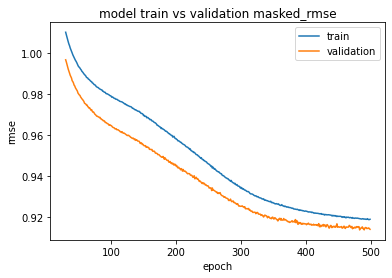

In [ ]:
show_rmse(hist_Sigmoid_Elu, 30)

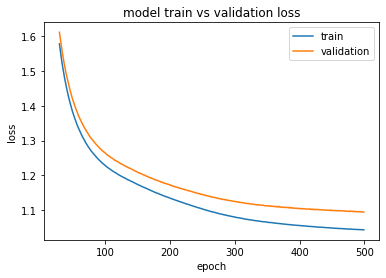

In [ ]:
show_error(hist_Sigmoid_Elu, 30)

In [ ]:
test_result_AutoRec_Sigmoid_Elu = AutoRec_Sigmoid_Elu.evaluate(users_items_matrix_train_zero, users_items_matrix_test.astype(float))

189/189 [==============================] - 1s 3ms/step - loss: 1.0819 - masked_rmse_clip: 0.9109


## Build model with Tanh, ELU activation

In [ ]:
AutoRec_Tanh_Elu = AutoRec(users_items_matrix_train_zero, 0.001, 'tanh', 'elu')

AutoRec_Tanh_Elu.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
 
AutoRec_Tanh_Elu.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 LatentSpace (Dense)         (None, 500)               1976500   
                                                                 
 UserScorePred (Dense)       (None, 3952)              1979952   
                                                                 
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_Autorec_Tanh_Elu = AutoRec_Tanh_Elu.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate.astype(float)])

Epoch 1/500
24/24 - 1s - loss: 15.4564 - masked_rmse_clip: 2.8945 - val_loss: 13.7553 - val_masked_rmse_clip: 2.8554 - 1s/epoch - 60ms/step
Epoch 2/500
24/24 - 0s - loss: 11.3140 - masked_rmse_clip: 2.7519 - val_loss: 8.8077 - val_masked_rmse_clip: 2.4783 - 425ms/epoch - 18ms/step
Epoch 3/500
24/24 - 0s - loss: 6.7260 - masked_rmse_clip: 2.1360 - val_loss: 5.0972 - val_masked_rmse_clip: 1.7436 - 440ms/epoch - 18ms/step
Epoch 4/500
24/24 - 0s - loss: 4.1424 - masked_rmse_clip: 1.5158 - val_loss: 3.5737 - val_masked_rmse_clip: 1.3184 - 410ms/epoch - 17ms/step
Epoch 5/500
24/24 - 0s - loss: 3.2266 - masked_rmse_clip: 1.2495 - val_loss: 3.0961 - val_masked_rmse_clip: 1.1827 - 425ms/epoch - 18ms/step
Epoch 6/500
24/24 - 0s - loss: 2.9137 - masked_rmse_clip: 1.1640 - val_loss: 2.8899 - val_masked_rmse_clip: 1.1330 - 420ms/epoch - 17ms/step
Epoch 7/500
24/24 - 0s - loss: 2.7441 - masked_rmse_clip: 1.1251 - val_loss: 2.7489 - val_masked_rmse_clip: 1.1045 - 405ms/epoch - 17ms/step
Epoch 8/500
2

In [ ]:
print(sorted(hist_Autorec_Tanh_Elu.history['val_masked_rmse_clip']))

[0.9159359335899353, 0.916111409664154, 0.9161127209663391, 0.9161129593849182, 0.9162219166755676, 0.9163035750389099, 0.9164056181907654, 0.9164705276489258, 0.9164721965789795, 0.9165941476821899, 0.9166343212127686, 0.916652262210846, 0.9166885614395142, 0.916691243648529, 0.9167188405990601, 0.9167301058769226, 0.9167441129684448, 0.9167701005935669, 0.916776180267334, 0.9168092608451843, 0.9168574810028076, 0.9168772101402283, 0.9169207811355591, 0.9170196652412415, 0.9170242547988892, 0.9170470237731934, 0.9170697331428528, 0.9170917272567749, 0.9171006679534912, 0.917110800743103, 0.9171655178070068, 0.9171750545501709, 0.9171808958053589, 0.9172161817550659, 0.9172229170799255, 0.9172545075416565, 0.9172546863555908, 0.9173198342323303, 0.917320966720581, 0.9173719882965088, 0.9173760414123535, 0.9173793196678162, 0.91746586561203, 0.917523980140686, 0.9176933765411377, 0.9177590608596802, 0.9177704453468323, 0.917788565158844, 0.9178224205970764, 0.9179306626319885, 0.9180693

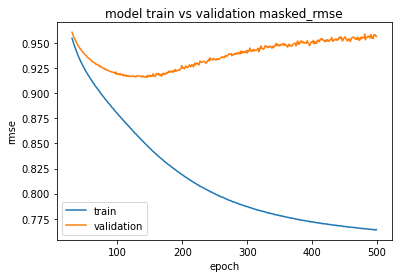

In [ ]:
show_rmse(hist_Autorec_Tanh_Elu, 30)

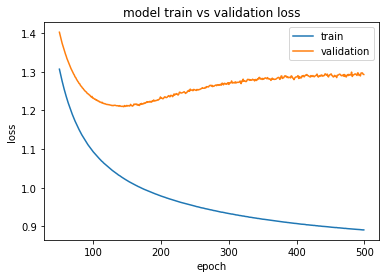

In [ ]:
show_error(hist_Autorec_Tanh_Elu, 50)

In [ ]:
test_result_AutoRec_Tanh_Elu = AutoRec_Tanh_Elu.evaluate(users_items_matrix_train_zero, users_items_matrix_test.astype(float))

189/189 [==============================] - 1s 3ms/step - loss: 1.2984 - masked_rmse_clip: 0.9610


## Build model with Elu, Elu activation

In [ ]:
AutoRec_Elu_Elu = AutoRec(users_items_matrix_train_zero, 0.01, 'elu', 'elu')

AutoRec_Elu_Elu.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
 
AutoRec_Elu_Elu.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 LatentSpace (Dense)         (None, 500)               1976500   
                                                                 
 UserScorePred (Dense)       (None, 3952)              1979952   
                                                                 
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_Autorec_Elu_Elu = AutoRec_Elu_Elu.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate.astype(float)])

Epoch 1/500
24/24 - 1s - loss: 30.0145 - masked_rmse_clip: 2.8679 - val_loss: 26.6123 - val_masked_rmse_clip: 2.7430 - 1s/epoch - 53ms/step
Epoch 2/500
24/24 - 0s - loss: 23.2330 - masked_rmse_clip: 2.5002 - val_loss: 20.8162 - val_masked_rmse_clip: 2.2199 - 427ms/epoch - 18ms/step
Epoch 3/500
24/24 - 0s - loss: 19.1050 - masked_rmse_clip: 2.1426 - val_loss: 17.7668 - val_masked_rmse_clip: 2.0848 - 434ms/epoch - 18ms/step
Epoch 4/500
24/24 - 0s - loss: 16.3593 - masked_rmse_clip: 1.9944 - val_loss: 15.3251 - val_masked_rmse_clip: 1.9105 - 406ms/epoch - 17ms/step
Epoch 5/500
24/24 - 0s - loss: 14.1380 - masked_rmse_clip: 1.8312 - val_loss: 13.3401 - val_masked_rmse_clip: 1.7700 - 398ms/epoch - 17ms/step
Epoch 6/500
24/24 - 0s - loss: 12.3402 - masked_rmse_clip: 1.6955 - val_loss: 11.7395 - val_masked_rmse_clip: 1.6599 - 396ms/epoch - 17ms/step
Epoch 7/500
24/24 - 0s - loss: 10.8852 - masked_rmse_clip: 1.5937 - val_loss: 10.4228 - val_masked_rmse_clip: 1.5690 - 382ms/epoch - 16ms/step
Ep

In [ ]:
print(sorted(hist_Autorec_Elu_Elu.history['val_masked_rmse_clip']))

[0.9616812467575073, 0.9625936150550842, 0.9626028537750244, 0.9632101058959961, 0.9632901549339294, 0.9633355736732483, 0.9634069800376892, 0.9635535478591919, 0.9640888571739197, 0.96417236328125, 0.9643482565879822, 0.9648555517196655, 0.9650218486785889, 0.9651037454605103, 0.9651301503181458, 0.9654422998428345, 0.9654977321624756, 0.9658883810043335, 0.9659959673881531, 0.9660148024559021, 0.9660202264785767, 0.9660866260528564, 0.9661814570426941, 0.9661818146705627, 0.9667025208473206, 0.9667299389839172, 0.9670463800430298, 0.9673706293106079, 0.9678024649620056, 0.9678948521614075, 0.9680746793746948, 0.968147873878479, 0.9683899283409119, 0.9686139225959778, 0.9687004685401917, 0.9689508676528931, 0.9693129658699036, 0.9693524837493896, 0.9694127440452576, 0.9699001908302307, 0.9701122045516968, 0.9701184034347534, 0.9703673720359802, 0.9703927040100098, 0.9704455733299255, 0.9706057906150818, 0.9714317321777344, 0.9716184139251709, 0.9716819524765015, 0.9721455574035645, 0.

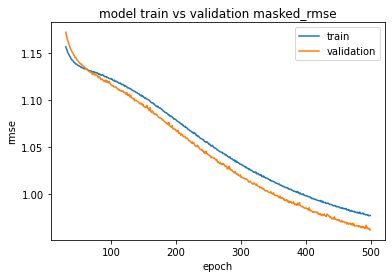

In [ ]:
show_rmse(hist_Autorec_Elu_Elu, 30)

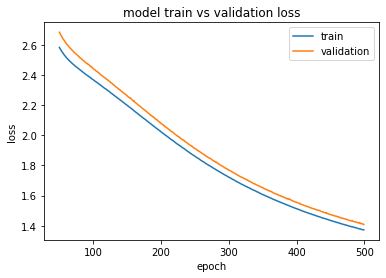

In [ ]:
show_error(hist_Autorec_Elu_Elu, 50)

In [ ]:
test_result_AutoRec_Elu_Elu = AutoRec_Elu_Elu.evaluate(users_items_matrix_train_zero, users_items_matrix_test.astype(float))

189/189 [==============================] - 1s 3ms/step - loss: 1.3889 - masked_rmse_clip: 0.9560


## Build model with Elu, Linear activation

In [ ]:
AutoRec_Elu_Linear = AutoRec(users_items_matrix_train_zero, 0.01, 'elu', 'linear')

AutoRec_Elu_Linear.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
 
AutoRec_Elu_Linear.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 LatentSpace (Dense)         (None, 500)               1976500   
                                                                 
 UserScorePred (Dense)       (None, 3952)              1979952   
                                                                 
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_Autorec_Elu_Linear = AutoRec_Elu_Linear.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate.astype(float)])

Epoch 1/500
24/24 - 6s - loss: 30.0221 - masked_rmse_clip: 2.8668 - val_loss: 26.5382 - val_masked_rmse_clip: 2.7375 - 6s/epoch - 240ms/step
Epoch 2/500
24/24 - 1s - loss: 23.2285 - masked_rmse_clip: 2.4903 - val_loss: 20.8742 - val_masked_rmse_clip: 2.2221 - 819ms/epoch - 34ms/step
Epoch 3/500
24/24 - 1s - loss: 19.1809 - masked_rmse_clip: 2.1488 - val_loss: 17.8784 - val_masked_rmse_clip: 2.0950 - 748ms/epoch - 31ms/step
Epoch 4/500
24/24 - 1s - loss: 16.4935 - masked_rmse_clip: 2.0004 - val_loss: 15.4656 - val_masked_rmse_clip: 1.9274 - 557ms/epoch - 23ms/step
Epoch 5/500
24/24 - 1s - loss: 14.2854 - masked_rmse_clip: 1.8456 - val_loss: 13.4910 - val_masked_rmse_clip: 1.7888 - 613ms/epoch - 26ms/step
Epoch 6/500
24/24 - 1s - loss: 12.4918 - masked_rmse_clip: 1.7147 - val_loss: 11.8850 - val_masked_rmse_clip: 1.6747 - 645ms/epoch - 27ms/step
Epoch 7/500
24/24 - 1s - loss: 11.0302 - masked_rmse_clip: 1.6069 - val_loss: 10.5658 - val_masked_rmse_clip: 1.5886 - 575ms/epoch - 24ms/step
E

In [ ]:
print(sorted(hist_Autorec_Elu_Linear.history['val_masked_rmse_clip']))

[0.9622085690498352, 0.9624324440956116, 0.9626999497413635, 0.9627612233161926, 0.9629427790641785, 0.9633309841156006, 0.9635427594184875, 0.9639557003974915, 0.9640377759933472, 0.9640404582023621, 0.96442711353302, 0.9646000266075134, 0.9647919535636902, 0.9656020402908325, 0.9656261205673218, 0.9658926129341125, 0.9659312963485718, 0.9660801291465759, 0.9664407968521118, 0.9664653539657593, 0.9665477275848389, 0.9667930006980896, 0.9669927358627319, 0.9670213460922241, 0.9670422077178955, 0.9674771428108215, 0.9676479697227478, 0.9677780270576477, 0.9679082036018372, 0.9679715633392334, 0.9686490893363953, 0.9689496755599976, 0.9690127968788147, 0.9692362546920776, 0.9695335030555725, 0.9697297811508179, 0.9697680473327637, 0.9700036644935608, 0.9703380465507507, 0.9703640937805176, 0.9704133868217468, 0.9707849621772766, 0.970876932144165, 0.9710618257522583, 0.9714423418045044, 0.971457302570343, 0.9721411466598511, 0.9723933339118958, 0.9725484848022461, 0.972747266292572, 0.97

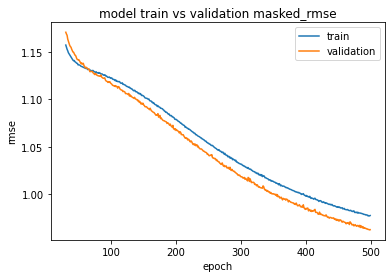

In [ ]:
show_rmse(hist_Autorec_Elu_Linear, 30)

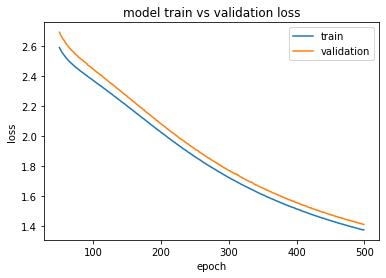

In [ ]:
show_error(hist_Autorec_Elu_Linear, 50)

In [ ]:
test_result_AutoRec_Elu_Linear = AutoRec_Elu_Linear.evaluate(users_items_matrix_train_zero, users_items_matrix_test.astype(float))

189/189 [==============================] - 1s 3ms/step - loss: 1.3907 - masked_rmse_clip: 0.9565


## Build model with SELU, SELU activation

In [ ]:
AutoRec_SELU_SELU = AutoRec(users_items_matrix_train_zero, 0.01, 'selu', 'selu')

AutoRec_SELU_SELU.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
 
AutoRec_SELU_SELU.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 LatentSpace (Dense)         (None, 500)               1976500   
                                                                 
 UserScorePred (Dense)       (None, 3952)              1979952   
                                                                 
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_Autorec_SELU_SELU = AutoRec_SELU_SELU.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate.astype(float)])

Epoch 1/500
24/24 - 1s - loss: 30.1487 - masked_rmse_clip: 2.8520 - val_loss: 26.3282 - val_masked_rmse_clip: 2.7027 - 1s/epoch - 50ms/step
Epoch 2/500
24/24 - 0s - loss: 22.7332 - masked_rmse_clip: 2.4165 - val_loss: 20.1306 - val_masked_rmse_clip: 2.0957 - 432ms/epoch - 18ms/step
Epoch 3/500
24/24 - 0s - loss: 18.3188 - masked_rmse_clip: 1.9517 - val_loss: 16.9477 - val_masked_rmse_clip: 1.8417 - 412ms/epoch - 17ms/step
Epoch 4/500
24/24 - 0s - loss: 15.5353 - masked_rmse_clip: 1.7316 - val_loss: 14.5408 - val_masked_rmse_clip: 1.6478 - 432ms/epoch - 18ms/step
Epoch 5/500
24/24 - 0s - loss: 13.3889 - masked_rmse_clip: 1.5503 - val_loss: 12.6401 - val_masked_rmse_clip: 1.4954 - 417ms/epoch - 17ms/step
Epoch 6/500
24/24 - 1s - loss: 11.6941 - masked_rmse_clip: 1.4190 - val_loss: 11.1220 - val_masked_rmse_clip: 1.3875 - 543ms/epoch - 23ms/step
Epoch 7/500
24/24 - 0s - loss: 10.3231 - masked_rmse_clip: 1.3277 - val_loss: 9.8736 - val_masked_rmse_clip: 1.3130 - 408ms/epoch - 17ms/step
Epo

In [ ]:
print(sorted(hist_Autorec_SELU_SELU.history['val_masked_rmse_clip']))

[0.9461157321929932, 0.9464950561523438, 0.946724534034729, 0.9471451044082642, 0.947356641292572, 0.9474226832389832, 0.947511613368988, 0.9478029012680054, 0.9478259086608887, 0.9480459094047546, 0.9482350945472717, 0.9483563303947449, 0.9484241604804993, 0.9484264254570007, 0.9485589861869812, 0.9485785961151123, 0.9489977955818176, 0.9490112066268921, 0.9491699934005737, 0.9493707418441772, 0.9493722915649414, 0.9494283199310303, 0.9494729042053223, 0.9495489597320557, 0.9495716094970703, 0.9496082663536072, 0.9496899843215942, 0.9498105049133301, 0.9498143792152405, 0.9498363137245178, 0.9499067664146423, 0.9499096274375916, 0.9499577879905701, 0.9500018358230591, 0.9501851797103882, 0.9502313733100891, 0.9503800272941589, 0.9504453539848328, 0.9505935907363892, 0.9505982398986816, 0.9506574273109436, 0.9506754875183105, 0.9507455825805664, 0.9508315920829773, 0.9509468078613281, 0.9509894251823425, 0.9511081576347351, 0.9513819813728333, 0.951414942741394, 0.9514328241348267, 0.9

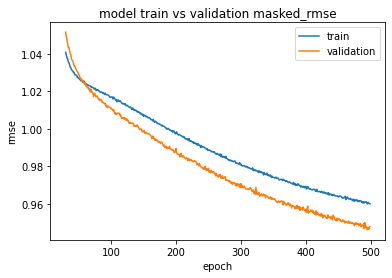

In [ ]:
show_rmse(hist_Autorec_SELU_SELU, 30)

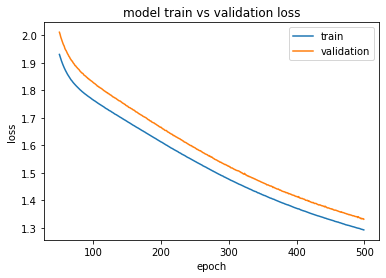

In [ ]:
show_error(hist_Autorec_SELU_SELU, 50)

In [ ]:
test_result_AutoRec_SELU_SELU = AutoRec_SELU_SELU.evaluate(users_items_matrix_train_zero, users_items_matrix_test.astype(float))

189/189 [==============================] - 1s 3ms/step - loss: 1.3133 - masked_rmse_clip: 0.9430


## Build model with SELU, Linear activation

In [ ]:
AutoRec_Selu_Linear = AutoRec(users_items_matrix_train_zero, 0.01, 'selu', 'linear')

AutoRec_Selu_Linear.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
 
AutoRec_Selu_Linear.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 LatentSpace (Dense)         (None, 500)               1976500   
                                                                 
 UserScorePred (Dense)       (None, 3952)              1979952   
                                                                 
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_Autorec_Selu_Linear = AutoRec_Selu_Linear.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate.astype(float)])

Epoch 1/500
24/24 - 1s - loss: 29.7683 - masked_rmse_clip: 2.8516 - val_loss: 26.0158 - val_masked_rmse_clip: 2.6952 - 1s/epoch - 61ms/step
Epoch 2/500
24/24 - 0s - loss: 22.4943 - masked_rmse_clip: 2.4086 - val_loss: 19.9053 - val_masked_rmse_clip: 2.0791 - 439ms/epoch - 18ms/step
Epoch 3/500
24/24 - 0s - loss: 18.0951 - masked_rmse_clip: 1.9385 - val_loss: 16.6906 - val_masked_rmse_clip: 1.8243 - 430ms/epoch - 18ms/step
Epoch 4/500
24/24 - 0s - loss: 15.3023 - masked_rmse_clip: 1.7192 - val_loss: 14.2853 - val_masked_rmse_clip: 1.6264 - 436ms/epoch - 18ms/step
Epoch 5/500
24/24 - 0s - loss: 13.1614 - masked_rmse_clip: 1.5360 - val_loss: 12.4012 - val_masked_rmse_clip: 1.4802 - 417ms/epoch - 17ms/step
Epoch 6/500
24/24 - 0s - loss: 11.4759 - masked_rmse_clip: 1.4110 - val_loss: 10.8961 - val_masked_rmse_clip: 1.3772 - 403ms/epoch - 17ms/step
Epoch 7/500
24/24 - 0s - loss: 10.1135 - masked_rmse_clip: 1.3219 - val_loss: 9.6587 - val_masked_rmse_clip: 1.3064 - 421ms/epoch - 18ms/step
Epo

In [ ]:
print(sorted(hist_Autorec_Selu_Linear.history['val_masked_rmse_clip']))

[0.9507434964179993, 0.9509485363960266, 0.9511646628379822, 0.9513143301010132, 0.9513786435127258, 0.9515466690063477, 0.9516598582267761, 0.9517912864685059, 0.951816201210022, 0.9518489837646484, 0.9520726799964905, 0.952125072479248, 0.9521704912185669, 0.95220947265625, 0.9523685574531555, 0.9524056911468506, 0.9524199962615967, 0.9526230692863464, 0.9526552557945251, 0.9526930451393127, 0.9527215361595154, 0.9528829455375671, 0.952963650226593, 0.953069806098938, 0.9531177282333374, 0.9531431198120117, 0.953178346157074, 0.9532365798950195, 0.9532885551452637, 0.9534086585044861, 0.9535210132598877, 0.9535363912582397, 0.9537619352340698, 0.9538191556930542, 0.9541548490524292, 0.9541645646095276, 0.9541743993759155, 0.9541982412338257, 0.9543143510818481, 0.9543164968490601, 0.9543837904930115, 0.9547010660171509, 0.9548110365867615, 0.9551339745521545, 0.9551852941513062, 0.9552388191223145, 0.9552612900733948, 0.9552923440933228, 0.9554826021194458, 0.9556326270103455, 0.9557

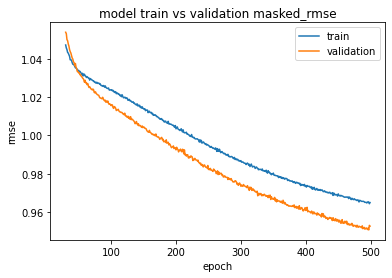

In [ ]:
show_rmse(hist_Autorec_Selu_Linear, 30)

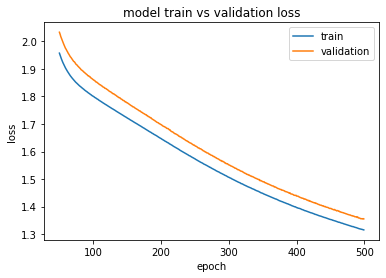

In [ ]:
show_error(hist_Autorec_Selu_Linear, 50)

In [ ]:
test_result_AutoRec_Selu_Linear = AutoRec_Selu_Linear.evaluate(users_items_matrix_train_zero, users_items_matrix_test.astype(float))

189/189 [==============================] - 1s 3ms/step - loss: 1.3349 - masked_rmse_clip: 0.9465


## Build model with LeakyRELU, Linear activation

In [ ]:
AutoRec_LReLU_Linear = AutoRec_LReLU(users_items_matrix_train_zero, 0.01)

AutoRec_LReLU_Linear.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
 
AutoRec_LReLU_Linear.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 LatentSpace (Dense)         (None, 500)               1976500   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 500)               0         
                                                                 
 UserScorePred (Dense)       (None, 3952)              1979952   
                                                                 
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_Autorec_LReLU_Linear = AutoRec_LReLU_Linear.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate.astype(float)])

Epoch 1/500
24/24 - 1s - loss: 30.0109 - masked_rmse_clip: 2.8667 - val_loss: 26.4409 - val_masked_rmse_clip: 2.7291 - 1s/epoch - 51ms/step
Epoch 2/500
24/24 - 0s - loss: 23.2925 - masked_rmse_clip: 2.4910 - val_loss: 21.1801 - val_masked_rmse_clip: 2.2442 - 425ms/epoch - 18ms/step
Epoch 3/500
24/24 - 0s - loss: 19.5897 - masked_rmse_clip: 2.2116 - val_loss: 18.2979 - val_masked_rmse_clip: 2.1640 - 412ms/epoch - 17ms/step
Epoch 4/500
24/24 - 0s - loss: 16.9773 - masked_rmse_clip: 2.0940 - val_loss: 15.9822 - val_masked_rmse_clip: 2.0326 - 413ms/epoch - 17ms/step
Epoch 5/500
24/24 - 0s - loss: 14.8395 - masked_rmse_clip: 1.9605 - val_loss: 14.0940 - val_masked_rmse_clip: 1.9167 - 423ms/epoch - 18ms/step
Epoch 6/500
24/24 - 0s - loss: 13.1174 - masked_rmse_clip: 1.8552 - val_loss: 12.5774 - val_masked_rmse_clip: 1.8367 - 432ms/epoch - 18ms/step
Epoch 7/500
24/24 - 0s - loss: 11.7131 - masked_rmse_clip: 1.7768 - val_loss: 11.3116 - val_masked_rmse_clip: 1.7600 - 417ms/epoch - 17ms/step
Ep

In [ ]:
print(sorted(hist_Autorec_LReLU_Linear.history['val_masked_rmse_clip']))

[0.9557175040245056, 0.9559682011604309, 0.9567158222198486, 0.957059383392334, 0.9576219320297241, 0.9577586650848389, 0.9578073024749756, 0.9579283595085144, 0.9580466151237488, 0.9581689834594727, 0.9582503437995911, 0.9586679339408875, 0.958694577217102, 0.9587693214416504, 0.9588547348976135, 0.959333062171936, 0.9597242474555969, 0.9598460793495178, 0.9602687954902649, 0.9603816270828247, 0.9607808589935303, 0.9608592391014099, 0.9609605669975281, 0.9610357880592346, 0.9611753225326538, 0.9612694978713989, 0.9615346789360046, 0.9621102809906006, 0.9621348977088928, 0.9622730016708374, 0.9623317718505859, 0.9624814987182617, 0.9627891778945923, 0.9635177850723267, 0.9635236263275146, 0.9636788368225098, 0.963799774646759, 0.9639804363250732, 0.9640367031097412, 0.9643360376358032, 0.9647321701049805, 0.9647928476333618, 0.964819073677063, 0.9651283025741577, 0.9651901721954346, 0.9652794003486633, 0.9661505222320557, 0.9662593603134155, 0.9664969444274902, 0.9666589498519897, 0.96

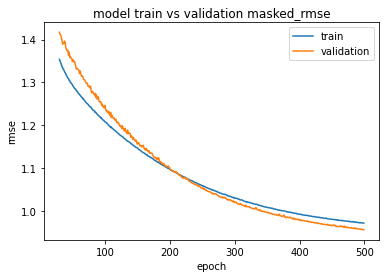

In [ ]:
show_rmse(hist_Autorec_LReLU_Linear, 30)

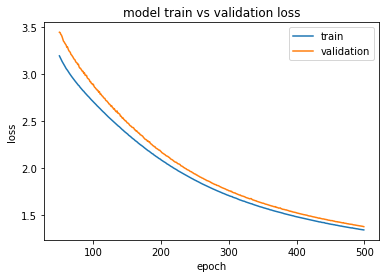

In [ ]:
show_error(hist_Autorec_LReLU_Linear, 50)

In [ ]:
test_result_AutoRec_LReLU_Linear = AutoRec_LReLU_Linear.evaluate(users_items_matrix_train_zero, users_items_matrix_test.astype(float))

189/189 [==============================] - 1s 3ms/step - loss: 1.3539 - masked_rmse_clip: 0.9500


# Build model with Sigmoid, Linear activation and Default Rating [0-5], average

## Build model with Default Rating = 0

In [ ]:
AutoRec_Sigmoid_Linear_DR_0 = AutoRec(users_items_matrix_train_zero, 0.001, 'sigmoid', 'linear')

AutoRec_Sigmoid_Linear_DR_0.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
 
AutoRec_Sigmoid_Linear_DR_0.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 LatentSpace (Dense)         (None, 500)               1976500   
                                                                 
 UserScorePred (Dense)       (None, 3952)              1979952   
                                                                 
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_AutoRec_Sigmoid_Linear_DR_0 = AutoRec_Sigmoid_Linear_DR_0.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate.astype(float)])

Epoch 1/500
24/24 - 1s - loss: 14.5950 - masked_rmse_clip: 2.8946 - val_loss: 12.1134 - val_masked_rmse_clip: 2.8493 - 1s/epoch - 60ms/step
Epoch 2/500
24/24 - 0s - loss: 9.7759 - masked_rmse_clip: 2.6897 - val_loss: 7.4186 - val_masked_rmse_clip: 2.3337 - 410ms/epoch - 17ms/step
Epoch 3/500
24/24 - 0s - loss: 5.8227 - masked_rmse_clip: 2.0045 - val_loss: 4.4855 - val_masked_rmse_clip: 1.6386 - 394ms/epoch - 16ms/step
Epoch 4/500
24/24 - 0s - loss: 3.7638 - masked_rmse_clip: 1.4532 - val_loss: 3.2489 - val_masked_rmse_clip: 1.2641 - 390ms/epoch - 16ms/step
Epoch 5/500
24/24 - 1s - loss: 2.9709 - masked_rmse_clip: 1.2029 - val_loss: 2.8092 - val_masked_rmse_clip: 1.1271 - 523ms/epoch - 22ms/step
Epoch 6/500
24/24 - 0s - loss: 2.6800 - masked_rmse_clip: 1.1197 - val_loss: 2.6297 - val_masked_rmse_clip: 1.0849 - 412ms/epoch - 17ms/step
Epoch 7/500
24/24 - 0s - loss: 2.5407 - masked_rmse_clip: 1.0932 - val_loss: 2.5228 - val_masked_rmse_clip: 1.0702 - 392ms/epoch - 16ms/step
Epoch 8/500
24

In [ ]:
print(sorted(hist_AutoRec_Sigmoid_Linear_DR_0.history['val_masked_rmse_clip']))

[0.9140082001686096, 0.9143266081809998, 0.9144515991210938, 0.9145014882087708, 0.9145115613937378, 0.914553701877594, 0.9145729541778564, 0.9145792126655579, 0.9146068096160889, 0.9146184325218201, 0.9146245121955872, 0.9146255850791931, 0.9146406054496765, 0.9146474599838257, 0.9146845936775208, 0.9146993160247803, 0.9147288203239441, 0.9147423505783081, 0.9147590398788452, 0.9147810935974121, 0.914781391620636, 0.9147924184799194, 0.9148275852203369, 0.9148334264755249, 0.9148475527763367, 0.9148581624031067, 0.9148757457733154, 0.9148975610733032, 0.9149215221405029, 0.9149265289306641, 0.914957582950592, 0.9149667620658875, 0.9149729609489441, 0.9149881601333618, 0.9150234460830688, 0.9150406718254089, 0.9150804281234741, 0.9151229858398438, 0.91517174243927, 0.9151829481124878, 0.915201723575592, 0.9152278304100037, 0.9152462482452393, 0.9152495861053467, 0.9152708053588867, 0.9152716398239136, 0.9152732491493225, 0.915286660194397, 0.9153188467025757, 0.9153335094451904, 0.9153

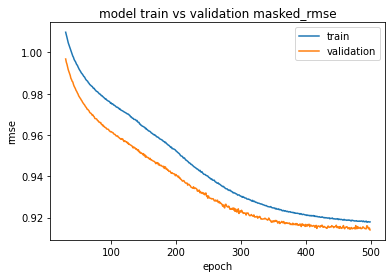

In [ ]:
show_rmse(hist_AutoRec_Sigmoid_Linear_DR_0, 30)

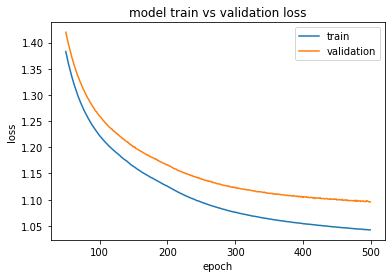

In [ ]:
show_error(hist_AutoRec_Sigmoid_Linear_DR_0, 50)

In [ ]:
test_result_hist_AutoRec_Sigmoid_Linear_DR_0 = AutoRec_Sigmoid_Linear_DR_0.evaluate(users_items_matrix_train_zero, users_items_matrix_test.astype(float))

189/189 [==============================] - 1s 3ms/step - loss: 1.0843 - masked_rmse_clip: 0.9114


## Build model with Default Rating = 1

In [ ]:
AutoRec_Sigmoid_Linear_DR_1 = AutoRec(users_items_matrix_train_zero, 0.001, 'sigmoid', 'linear')

AutoRec_Sigmoid_Linear_DR_1.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
 
AutoRec_Sigmoid_Linear_DR_1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 LatentSpace (Dense)         (None, 500)               1976500   
                                                                 
 UserScorePred (Dense)       (None, 3952)              1979952   
                                                                 
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_Autorec_Sigmoid_Linear_DR_1 = AutoRec_Sigmoid_Linear_DR_1.fit(x=users_items_matrix_train_one, y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_one, users_items_matrix_validate.astype(float)])

Epoch 1/500
24/24 - 1s - loss: 13.6632 - masked_rmse_clip: 2.8712 - val_loss: 10.7621 - val_masked_rmse_clip: 2.7484 - 1s/epoch - 52ms/step
Epoch 2/500
24/24 - 0s - loss: 8.5363 - masked_rmse_clip: 2.5053 - val_loss: 6.4163 - val_masked_rmse_clip: 2.1159 - 417ms/epoch - 17ms/step
Epoch 3/500
24/24 - 0s - loss: 5.1298 - masked_rmse_clip: 1.8312 - val_loss: 4.0153 - val_masked_rmse_clip: 1.4946 - 415ms/epoch - 17ms/step
Epoch 4/500
24/24 - 0s - loss: 3.4366 - masked_rmse_clip: 1.3326 - val_loss: 2.9955 - val_masked_rmse_clip: 1.1464 - 412ms/epoch - 17ms/step
Epoch 5/500
24/24 - 0s - loss: 2.7785 - masked_rmse_clip: 1.0918 - val_loss: 2.6334 - val_masked_rmse_clip: 1.0074 - 400ms/epoch - 17ms/step
Epoch 6/500
24/24 - 1s - loss: 2.5402 - masked_rmse_clip: 1.0054 - val_loss: 2.4946 - val_masked_rmse_clip: 0.9647 - 538ms/epoch - 22ms/step
Epoch 7/500
24/24 - 0s - loss: 2.4331 - masked_rmse_clip: 0.9798 - val_loss: 2.4137 - val_masked_rmse_clip: 0.9520 - 413ms/epoch - 17ms/step
Epoch 8/500
24

In [ ]:
print(sorted(hist_Autorec_Sigmoid_Linear_DR_1.history['val_masked_rmse_clip']))

[0.9217114448547363, 0.9218454360961914, 0.9219682216644287, 0.9220690727233887, 0.9221561551094055, 0.922186553478241, 0.9222312569618225, 0.9224007725715637, 0.9224282503128052, 0.9224704504013062, 0.9225013852119446, 0.9225130081176758, 0.922546923160553, 0.9225481748580933, 0.9225901961326599, 0.9225956797599792, 0.9225977063179016, 0.9226094484329224, 0.9226139783859253, 0.9226285219192505, 0.9226512312889099, 0.9226514101028442, 0.9227327108383179, 0.9227374196052551, 0.9227748513221741, 0.9227891564369202, 0.9228171110153198, 0.9228321313858032, 0.922849714756012, 0.922877848148346, 0.922895610332489, 0.9228973984718323, 0.9228996634483337, 0.9229055047035217, 0.9229447841644287, 0.9229466915130615, 0.9229540824890137, 0.9229879975318909, 0.9229938983917236, 0.9230080842971802, 0.9230380654335022, 0.9230532050132751, 0.9230610132217407, 0.9230645895004272, 0.9230855107307434, 0.9230996370315552, 0.9231036305427551, 0.9231162071228027, 0.9231284260749817, 0.9231311678886414, 0.92

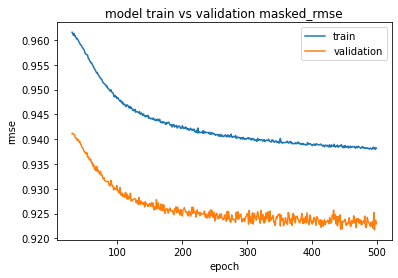

In [ ]:
show_rmse(hist_Autorec_Sigmoid_Linear_DR_1, 30)

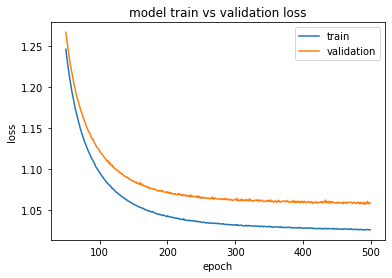

In [ ]:
show_error(hist_Autorec_Sigmoid_Linear_DR_1, 50)

In [ ]:
test_result_AutoRec_Sigmoid_Linear_DR_1 = AutoRec_Sigmoid_Linear_DR_1.evaluate(users_items_matrix_train_one, users_items_matrix_test.astype(float))

189/189 [==============================] - 1s 3ms/step - loss: 1.0467 - masked_rmse_clip: 0.9198


## Build model with Default Rating = 2

In [ ]:
AutoRec_Sigmoid_Linear_DR_2 = AutoRec(users_items_matrix_train_zero, 0.001, 'sigmoid', 'linear')

AutoRec_Sigmoid_Linear_DR_2.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
 
AutoRec_Sigmoid_Linear_DR_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 LatentSpace (Dense)         (None, 500)               1976500   
                                                                 
 UserScorePred (Dense)       (None, 3952)              1979952   
                                                                 
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_Autorec_Sigmoid_Linear_DR_2 = AutoRec_Sigmoid_Linear_DR_2.fit(x=users_items_matrix_train_two, y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_two, users_items_matrix_validate.astype(float)])

Epoch 1/500
24/24 - 6s - loss: 13.8923 - masked_rmse_clip: 2.8791 - val_loss: 11.2252 - val_masked_rmse_clip: 2.7864 - 6s/epoch - 229ms/step
Epoch 2/500
24/24 - 0s - loss: 9.3154 - masked_rmse_clip: 2.6295 - val_loss: 7.4325 - val_masked_rmse_clip: 2.3348 - 412ms/epoch - 17ms/step
Epoch 3/500
24/24 - 0s - loss: 6.1658 - masked_rmse_clip: 2.0984 - val_loss: 4.9860 - val_masked_rmse_clip: 1.7911 - 410ms/epoch - 17ms/step
Epoch 4/500
24/24 - 0s - loss: 4.2589 - masked_rmse_clip: 1.6199 - val_loss: 3.6089 - val_masked_rmse_clip: 1.3963 - 399ms/epoch - 17ms/step
Epoch 5/500
24/24 - 0s - loss: 3.2211 - masked_rmse_clip: 1.2948 - val_loss: 2.9016 - val_masked_rmse_clip: 1.1540 - 407ms/epoch - 17ms/step
Epoch 6/500
24/24 - 0s - loss: 2.7121 - masked_rmse_clip: 1.1122 - val_loss: 2.5709 - val_masked_rmse_clip: 1.0324 - 393ms/epoch - 16ms/step
Epoch 7/500
24/24 - 0s - loss: 2.4701 - masked_rmse_clip: 1.0257 - val_loss: 2.4110 - val_masked_rmse_clip: 0.9793 - 407ms/epoch - 17ms/step
Epoch 8/500
2

In [ ]:
print(sorted(hist_Autorec_Sigmoid_Linear_DR_2.history['val_masked_rmse_clip']))

[0.9306899309158325, 0.930713951587677, 0.9307140111923218, 0.9307189583778381, 0.9308713674545288, 0.9309041500091553, 0.930955708026886, 0.9309964179992676, 0.930997371673584, 0.9310954213142395, 0.9311115145683289, 0.9311193823814392, 0.9311232566833496, 0.9311248660087585, 0.9311776757240295, 0.931201159954071, 0.9312294721603394, 0.9312427043914795, 0.9312488436698914, 0.9312506318092346, 0.9312611818313599, 0.9312655925750732, 0.9312668442726135, 0.9312804937362671, 0.9312838912010193, 0.9312959313392639, 0.9313102960586548, 0.9313542246818542, 0.9313576817512512, 0.9313717484474182, 0.9313820004463196, 0.9313877820968628, 0.9313924312591553, 0.9314045906066895, 0.9314176440238953, 0.931418776512146, 0.9314305186271667, 0.9314395189285278, 0.9314424991607666, 0.931459367275238, 0.9314596056938171, 0.9314603209495544, 0.931479275226593, 0.9314801692962646, 0.9314929246902466, 0.9315078258514404, 0.9315168857574463, 0.9315187335014343, 0.9315235018730164, 0.9315325617790222, 0.9315

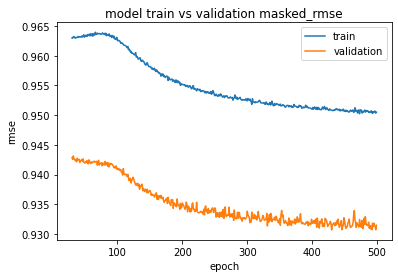

In [ ]:
show_rmse(hist_Autorec_Sigmoid_Linear_DR_2, 30)

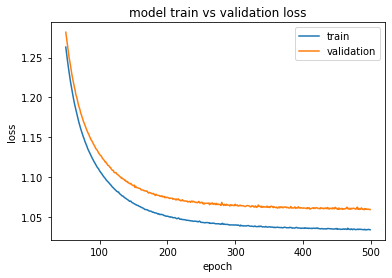

In [ ]:
show_error(hist_Autorec_Sigmoid_Linear_DR_2, 50)

In [ ]:
test_result_AutoRec_Sigmoid_Linear_DR_2 = AutoRec_Sigmoid_Linear_DR_2.evaluate(users_items_matrix_train_two, users_items_matrix_test.astype(float))

189/189 [==============================] - 1s 3ms/step - loss: 1.0465 - masked_rmse_clip: 0.9275


## Build model with Default Rating = 3

In [ ]:
AutoRec_Sigmoid_Linear_DR_3 = AutoRec(users_items_matrix_train_zero, 0.001, 'sigmoid', 'linear')

AutoRec_Sigmoid_Linear_DR_3.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
 
AutoRec_Sigmoid_Linear_DR_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 LatentSpace (Dense)         (None, 500)               1976500   
                                                                 
 UserScorePred (Dense)       (None, 3952)              1979952   
                                                                 
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_Autorec_Sigmoid_Linear_DR_3 = AutoRec_Sigmoid_Linear_DR_3.fit(x=users_items_matrix_train_three, y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_three, users_items_matrix_validate.astype(float)])

Epoch 1/500
24/24 - 1s - loss: 13.8883 - masked_rmse_clip: 2.8818 - val_loss: 11.4269 - val_masked_rmse_clip: 2.8033 - 1s/epoch - 49ms/step
Epoch 2/500
24/24 - 0s - loss: 9.6457 - masked_rmse_clip: 2.6757 - val_loss: 7.7867 - val_masked_rmse_clip: 2.4098 - 410ms/epoch - 17ms/step
Epoch 3/500
24/24 - 0s - loss: 6.5210 - masked_rmse_clip: 2.1884 - val_loss: 5.2729 - val_masked_rmse_clip: 1.8830 - 413ms/epoch - 17ms/step
Epoch 4/500
24/24 - 0s - loss: 4.4963 - masked_rmse_clip: 1.7075 - val_loss: 3.7545 - val_masked_rmse_clip: 1.4668 - 408ms/epoch - 17ms/step
Epoch 5/500
24/24 - 0s - loss: 3.3277 - masked_rmse_clip: 1.3586 - val_loss: 2.9460 - val_masked_rmse_clip: 1.2000 - 395ms/epoch - 16ms/step
Epoch 6/500
24/24 - 0s - loss: 2.7242 - masked_rmse_clip: 1.1476 - val_loss: 2.5449 - val_masked_rmse_clip: 1.0534 - 394ms/epoch - 16ms/step
Epoch 7/500
24/24 - 0s - loss: 2.4335 - masked_rmse_clip: 1.0421 - val_loss: 2.3600 - val_masked_rmse_clip: 0.9894 - 388ms/epoch - 16ms/step
Epoch 8/500
24

In [ ]:
print(sorted(hist_Autorec_Sigmoid_Linear_DR_3.history['val_masked_rmse_clip']))

[0.9413509368896484, 0.9414436221122742, 0.9414554834365845, 0.9414843320846558, 0.9414952397346497, 0.9415331482887268, 0.9415542483329773, 0.9415640234947205, 0.9415786862373352, 0.941590428352356, 0.9416102170944214, 0.9416131973266602, 0.9416161179542542, 0.9416343569755554, 0.9416505694389343, 0.9416571855545044, 0.9416599869728088, 0.9416662454605103, 0.9416833519935608, 0.9416990280151367, 0.9417217969894409, 0.9417229890823364, 0.9417598247528076, 0.9417810440063477, 0.9417886137962341, 0.9417951107025146, 0.9417990446090698, 0.9418030977249146, 0.9418098330497742, 0.9418110847473145, 0.9418184757232666, 0.9418264031410217, 0.9418286681175232, 0.9418296813964844, 0.9418332576751709, 0.9418350458145142, 0.9418427348136902, 0.9418447613716125, 0.9418624639511108, 0.9418643712997437, 0.941864550113678, 0.9418714046478271, 0.9418804049491882, 0.9418815970420837, 0.9418953657150269, 0.9418969750404358, 0.9419035911560059, 0.9419044852256775, 0.9419192671775818, 0.9419221878051758, 0

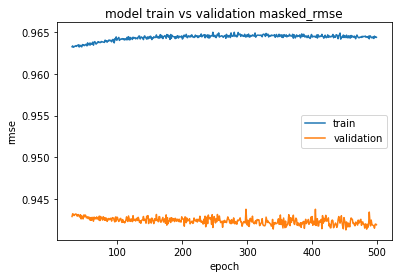

In [ ]:
show_rmse(hist_Autorec_Sigmoid_Linear_DR_3, 30)

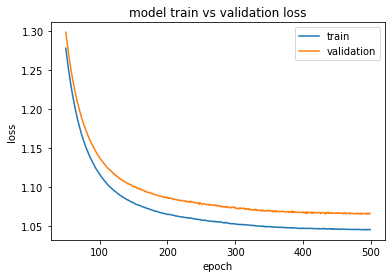

In [ ]:
show_error(hist_Autorec_Sigmoid_Linear_DR_3, 50)

In [ ]:
test_result_AutoRec_Sigmoid_Linear_DR_3 = AutoRec_Sigmoid_Linear_DR_3.evaluate(users_items_matrix_train_three, users_items_matrix_test.astype(float))

189/189 [==============================] - 1s 3ms/step - loss: 1.0535 - masked_rmse_clip: 0.9378


## Build model with Default Rating = 4

In [ ]:
AutoRec_Sigmoid_Linear_DR_4 = AutoRec(users_items_matrix_train_zero, 0.001, 'sigmoid', 'linear')

AutoRec_Sigmoid_Linear_DR_4.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
 
AutoRec_Sigmoid_Linear_DR_4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 LatentSpace (Dense)         (None, 500)               1976500   
                                                                 
 UserScorePred (Dense)       (None, 3952)              1979952   
                                                                 
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_Autorec_Sigmoid_Linear_DR_4 = AutoRec_Sigmoid_Linear_DR_4.fit(x=users_items_matrix_train_four, y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_four, users_items_matrix_validate.astype(float)])

Epoch 1/500
24/24 - 1s - loss: 13.8055 - masked_rmse_clip: 2.8783 - val_loss: 11.2356 - val_masked_rmse_clip: 2.7923 - 1s/epoch - 60ms/step
Epoch 2/500
24/24 - 0s - loss: 9.3780 - masked_rmse_clip: 2.6453 - val_loss: 7.5423 - val_masked_rmse_clip: 2.3684 - 421ms/epoch - 18ms/step
Epoch 3/500
24/24 - 0s - loss: 6.2925 - masked_rmse_clip: 2.1435 - val_loss: 5.1177 - val_masked_rmse_clip: 1.8481 - 413ms/epoch - 17ms/step
Epoch 4/500
24/24 - 0s - loss: 4.3615 - masked_rmse_clip: 1.6757 - val_loss: 3.6822 - val_masked_rmse_clip: 1.4514 - 417ms/epoch - 17ms/step
Epoch 5/500
24/24 - 0s - loss: 3.2580 - masked_rmse_clip: 1.3427 - val_loss: 2.8975 - val_masked_rmse_clip: 1.1914 - 417ms/epoch - 17ms/step
Epoch 6/500
24/24 - 0s - loss: 2.6706 - masked_rmse_clip: 1.1364 - val_loss: 2.5026 - val_masked_rmse_clip: 1.0464 - 402ms/epoch - 17ms/step
Epoch 7/500
24/24 - 0s - loss: 2.3877 - masked_rmse_clip: 1.0336 - val_loss: 2.3220 - val_masked_rmse_clip: 0.9839 - 424ms/epoch - 18ms/step
Epoch 8/500
24

In [ ]:
print(sorted(hist_Autorec_Sigmoid_Linear_DR_4.history['val_masked_rmse_clip']))

[0.9412283897399902, 0.9412757158279419, 0.9415208101272583, 0.9415494203567505, 0.9415762424468994, 0.9416195750236511, 0.9416646361351013, 0.9416779279708862, 0.9416787028312683, 0.9416898488998413, 0.9416971206665039, 0.9417344927787781, 0.9417431354522705, 0.9417638778686523, 0.9417767524719238, 0.9417852163314819, 0.941788375377655, 0.9418058395385742, 0.9418382048606873, 0.941841721534729, 0.9418470859527588, 0.9418554902076721, 0.941857099533081, 0.9418781399726868, 0.9418859481811523, 0.9418872594833374, 0.9418973326683044, 0.941909909248352, 0.9419193267822266, 0.9419258236885071, 0.9419273734092712, 0.9419304132461548, 0.9419443011283875, 0.9419562220573425, 0.9419565200805664, 0.9419676065444946, 0.941969633102417, 0.9419708251953125, 0.941975474357605, 0.9419832825660706, 0.9419859647750854, 0.9419877529144287, 0.9419952034950256, 0.9420150518417358, 0.9420174360275269, 0.9420210719108582, 0.9420344829559326, 0.9420350193977356, 0.9420381784439087, 0.9420397281646729, 0.942

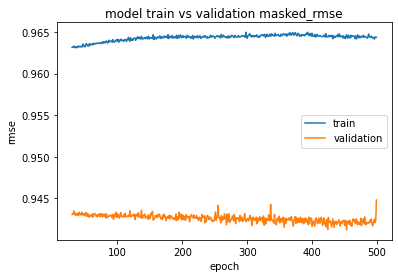

In [ ]:
show_rmse(hist_Autorec_Sigmoid_Linear_DR_4, 30)

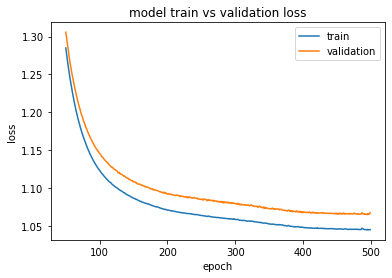

In [ ]:
show_error(hist_Autorec_Sigmoid_Linear_DR_4, 50)

In [ ]:
test_result_AutoRec_Sigmoid_Linear_DR_4 = AutoRec_Sigmoid_Linear_DR_4.evaluate(users_items_matrix_train_four, users_items_matrix_test.astype(float))

189/189 [==============================] - 1s 3ms/step - loss: 1.0540 - masked_rmse_clip: 0.9404


## Build model with Default Rating = 5

In [ ]:
AutoRec_Sigmoid_Linear_DR_5 = AutoRec(users_items_matrix_train_zero, 0.001, 'sigmoid', 'linear')

AutoRec_Sigmoid_Linear_DR_5.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
 
AutoRec_Sigmoid_Linear_DR_5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 LatentSpace (Dense)         (None, 500)               1976500   
                                                                 
 UserScorePred (Dense)       (None, 3952)              1979952   
                                                                 
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_Autorec_Sigmoid_Linear_DR_5 = AutoRec_Sigmoid_Linear_DR_5.fit(x=users_items_matrix_train_five, y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_five, users_items_matrix_validate.astype(float)])

Epoch 1/500
24/24 - 1s - loss: 14.0804 - masked_rmse_clip: 2.8853 - val_loss: 11.7230 - val_masked_rmse_clip: 2.8196 - 1s/epoch - 51ms/step
Epoch 2/500
24/24 - 0s - loss: 9.9279 - masked_rmse_clip: 2.7089 - val_loss: 8.1370 - val_masked_rmse_clip: 2.4789 - 393ms/epoch - 16ms/step
Epoch 3/500
24/24 - 0s - loss: 6.8252 - masked_rmse_clip: 2.2663 - val_loss: 5.5586 - val_masked_rmse_clip: 1.9712 - 398ms/epoch - 17ms/step
Epoch 4/500
24/24 - 0s - loss: 4.6937 - masked_rmse_clip: 1.7823 - val_loss: 3.9140 - val_masked_rmse_clip: 1.5417 - 406ms/epoch - 17ms/step
Epoch 5/500
24/24 - 0s - loss: 3.4197 - masked_rmse_clip: 1.4178 - val_loss: 2.9995 - val_masked_rmse_clip: 1.2516 - 393ms/epoch - 16ms/step
Epoch 6/500
24/24 - 0s - loss: 2.7235 - masked_rmse_clip: 1.1810 - val_loss: 2.5148 - val_masked_rmse_clip: 1.0759 - 413ms/epoch - 17ms/step
Epoch 7/500
24/24 - 0s - loss: 2.3782 - masked_rmse_clip: 1.0539 - val_loss: 2.2947 - val_masked_rmse_clip: 0.9964 - 387ms/epoch - 16ms/step
Epoch 8/500
24

In [ ]:
print(sorted(hist_Autorec_Sigmoid_Linear_DR_5.history['val_masked_rmse_clip']))

[0.9411745071411133, 0.9413563013076782, 0.9414934515953064, 0.9415717124938965, 0.9415825009346008, 0.9416152834892273, 0.9416660070419312, 0.941676676273346, 0.9417061805725098, 0.9417284727096558, 0.941746175289154, 0.9417502284049988, 0.9417949318885803, 0.9418242573738098, 0.9418285489082336, 0.9418527483940125, 0.9418596029281616, 0.9418607950210571, 0.9418700933456421, 0.9418779611587524, 0.9418788552284241, 0.9418942332267761, 0.9418953657150269, 0.9418992400169373, 0.9419000148773193, 0.9419017434120178, 0.9419056177139282, 0.9419127106666565, 0.9419173002243042, 0.9419292211532593, 0.9419294595718384, 0.9419375658035278, 0.9419426918029785, 0.9419469237327576, 0.9419485926628113, 0.9419525861740112, 0.9419564008712769, 0.9419680237770081, 0.941973090171814, 0.9419752359390259, 0.9419767260551453, 0.9419969320297241, 0.9420097470283508, 0.9420145153999329, 0.9420148134231567, 0.9420257210731506, 0.9420261383056641, 0.9420270323753357, 0.9420318603515625, 0.9420377016067505, 0.

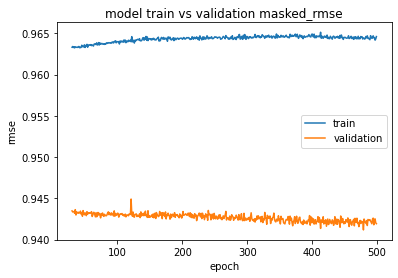

In [ ]:
show_rmse(hist_Autorec_Sigmoid_Linear_DR_5, 30)

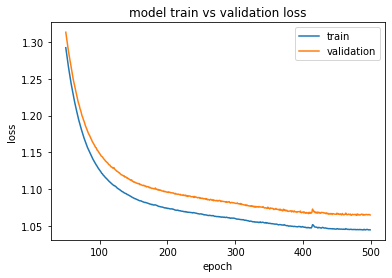

In [ ]:
show_error(hist_Autorec_Sigmoid_Linear_DR_5, 50)

In [ ]:
test_result_AutoRec_Sigmoid_Linear_DR_5 = AutoRec_Sigmoid_Linear_DR_5.evaluate(users_items_matrix_train_five, users_items_matrix_test.astype(float))

189/189 [==============================] - 1s 3ms/step - loss: 1.0525 - masked_rmse_clip: 0.9378


##Build model with Default Rating = average of total ratings

In [ ]:
AutoRec_Sigmoid_Linear_DR_avg = AutoRec(users_items_matrix_train_zero, 0.001, 'sigmoid', 'linear')

AutoRec_Sigmoid_Linear_DR_avg.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
 
AutoRec_Sigmoid_Linear_DR_avg.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 LatentSpace (Dense)         (None, 500)               1976500   
                                                                 
 UserScorePred (Dense)       (None, 3952)              1979952   
                                                                 
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_Autorec_Sigmoid_Linear_DR_avg = AutoRec_Sigmoid_Linear_DR_avg.fit(x=users_items_matrix_train_average, y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_average, users_items_matrix_validate.astype(float)])

Epoch 1/500
24/24 - 1s - loss: 13.9845 - masked_rmse_clip: 2.8803 - val_loss: 11.5880 - val_masked_rmse_clip: 2.8053 - 1s/epoch - 46ms/step
Epoch 2/500
24/24 - 0s - loss: 9.7931 - masked_rmse_clip: 2.6860 - val_loss: 8.0068 - val_masked_rmse_clip: 2.4482 - 354ms/epoch - 15ms/step
Epoch 3/500
24/24 - 0s - loss: 6.7235 - masked_rmse_clip: 2.2363 - val_loss: 5.4782 - val_masked_rmse_clip: 1.9417 - 330ms/epoch - 14ms/step
Epoch 4/500
24/24 - 0s - loss: 4.6446 - masked_rmse_clip: 1.7588 - val_loss: 3.8855 - val_masked_rmse_clip: 1.5204 - 330ms/epoch - 14ms/step
Epoch 5/500
24/24 - 0s - loss: 3.4148 - masked_rmse_clip: 1.4028 - val_loss: 3.0094 - val_masked_rmse_clip: 1.2406 - 310ms/epoch - 13ms/step
Epoch 6/500
24/24 - 0s - loss: 2.7517 - masked_rmse_clip: 1.1768 - val_loss: 2.5502 - val_masked_rmse_clip: 1.0750 - 305ms/epoch - 13ms/step
Epoch 7/500
24/24 - 0s - loss: 2.4188 - masked_rmse_clip: 1.0554 - val_loss: 2.3350 - val_masked_rmse_clip: 0.9986 - 313ms/epoch - 13ms/step
Epoch 8/500
24

In [ ]:
print(sorted(hist_Autorec_Sigmoid_Linear_DR_avg.history['val_masked_rmse_clip']))

[0.9089175462722778, 0.9093425869941711, 0.909400463104248, 0.9094387888908386, 0.9094496965408325, 0.9095242619514465, 0.9095554947853088, 0.9095742106437683, 0.9096253514289856, 0.9096311330795288, 0.9096711277961731, 0.9097343683242798, 0.9098166227340698, 0.909932017326355, 0.9099390506744385, 0.9099529981613159, 0.9099802374839783, 0.909987211227417, 0.9101309180259705, 0.9101315140724182, 0.910158097743988, 0.9101992845535278, 0.910250186920166, 0.9103185534477234, 0.9103354811668396, 0.9103866219520569, 0.9104113578796387, 0.9104206562042236, 0.9105890989303589, 0.9105901122093201, 0.9106309413909912, 0.9107354879379272, 0.9107629656791687, 0.9107885956764221, 0.9108195304870605, 0.9108511805534363, 0.9108880162239075, 0.9109183549880981, 0.9109886884689331, 0.9109981060028076, 0.9110129475593567, 0.9110773801803589, 0.9111007452011108, 0.9111132621765137, 0.911125123500824, 0.9111678004264832, 0.9111704230308533, 0.9111961126327515, 0.9112080931663513, 0.9112122654914856, 0.911

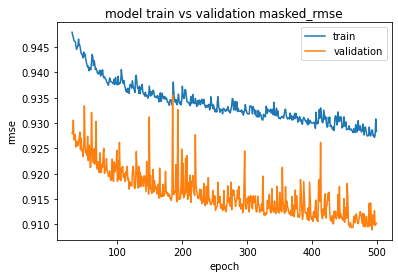

In [ ]:
show_rmse(hist_Autorec_Sigmoid_Linear_DR_avg, 30)

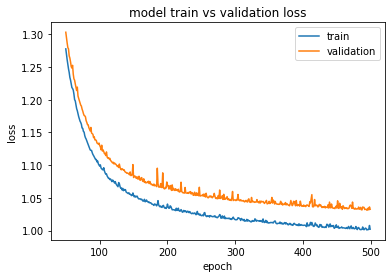

In [ ]:
show_error(hist_Autorec_Sigmoid_Linear_DR_avg, 50)

In [ ]:
test_result_AutoRec_Sigmoid_Linear_DR_avg = AutoRec_Sigmoid_Linear_DR_avg.evaluate(users_items_matrix_train_average, users_items_matrix_test.astype(float))

189/189 [==============================] - 1s 3ms/step - loss: 1.0196 - masked_rmse_clip: 0.9063


## Build model with Default Rating = average and ELU, ELU activation

In [ ]:
AutoRec_Elu_Elu_DR_avg = AutoRec(users_items_matrix_train_zero, 0.001, 'elu', 'elu')

AutoRec_Elu_Elu_DR_avg.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
 
AutoRec_Elu_Elu_DR_avg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 LatentSpace (Dense)         (None, 500)               1976500   
                                                                 
 UserScorePred (Dense)       (None, 3952)              1979952   
                                                                 
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_AutoRec_Elu_Elu_DR_avg = AutoRec_Elu_Elu_DR_avg.fit(x=users_items_matrix_train_average, y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_average, users_items_matrix_validate.astype(float)])

Epoch 1/500
24/24 - 4s - loss: 8.5599 - masked_rmse_clip: 1.9347 - val_loss: 4.6745 - val_masked_rmse_clip: 1.3644 - 4s/epoch - 168ms/step
Epoch 2/500
24/24 - 0s - loss: 3.5275 - masked_rmse_clip: 1.1824 - val_loss: 2.9461 - val_masked_rmse_clip: 1.0010 - 318ms/epoch - 13ms/step
Epoch 3/500
24/24 - 0s - loss: 2.7077 - masked_rmse_clip: 0.9856 - val_loss: 2.5897 - val_masked_rmse_clip: 0.9266 - 323ms/epoch - 13ms/step
Epoch 4/500
24/24 - 0s - loss: 2.4759 - masked_rmse_clip: 0.9376 - val_loss: 2.4436 - val_masked_rmse_clip: 0.9101 - 302ms/epoch - 13ms/step
Epoch 5/500
24/24 - 0s - loss: 2.3736 - masked_rmse_clip: 0.9248 - val_loss: 2.3838 - val_masked_rmse_clip: 0.9078 - 321ms/epoch - 13ms/step
Epoch 6/500
24/24 - 0s - loss: 2.3170 - masked_rmse_clip: 0.9231 - val_loss: 2.3320 - val_masked_rmse_clip: 0.9072 - 307ms/epoch - 13ms/step
Epoch 7/500
24/24 - 0s - loss: 2.2693 - masked_rmse_clip: 0.9233 - val_loss: 2.2868 - val_masked_rmse_clip: 0.9084 - 302ms/epoch - 13ms/step
Epoch 8/500
24/

In [ ]:
print(sorted(hist_AutoRec_Elu_Elu_DR_avg.history['val_masked_rmse_clip']))

[0.86783367395401, 0.8694378137588501, 0.8696739077568054, 0.8703408241271973, 0.8703858256340027, 0.8707068562507629, 0.8707371354103088, 0.8707661032676697, 0.8708119988441467, 0.8709093332290649, 0.8711683750152588, 0.8711793422698975, 0.8712265491485596, 0.8713560700416565, 0.871396005153656, 0.8714364171028137, 0.8714475035667419, 0.8714994788169861, 0.8718395829200745, 0.8719682097434998, 0.8719729781150818, 0.8720473647117615, 0.8721000552177429, 0.8721526265144348, 0.872154712677002, 0.8721727132797241, 0.8722025752067566, 0.8722206950187683, 0.8722493052482605, 0.8722513914108276, 0.8723276257514954, 0.872349202632904, 0.8723906874656677, 0.8724093437194824, 0.8725239038467407, 0.8725311160087585, 0.8725663423538208, 0.8725740909576416, 0.8726136684417725, 0.8726460933685303, 0.8727151155471802, 0.8727682828903198, 0.8728095293045044, 0.8728542923927307, 0.8728690147399902, 0.8728696703910828, 0.8728893995285034, 0.8729523420333862, 0.8729709386825562, 0.8730069398880005, 0.87

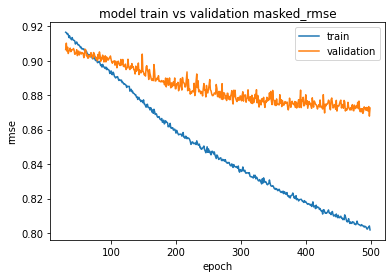

In [ ]:
show_rmse(hist_AutoRec_Elu_Elu_DR_avg, 30)

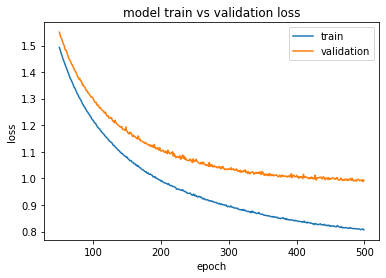

In [ ]:
show_error(hist_AutoRec_Elu_Elu_DR_avg, 50)

In [ ]:
test_result_hist_AutoRec_Elu_Elu_DR_avg = AutoRec_Elu_Elu_DR_avg.evaluate(users_items_matrix_train_average, users_items_matrix_test.astype(float))

189/189 [==============================] - 1s 3ms/step - loss: 0.9943 - masked_rmse_clip: 0.8762


## Build model with Default Rating = average and SELU, SELU activation

In [ ]:
AutoRec_SElu_SElu_DR_avg = AutoRec(users_items_matrix_train_zero, 0.001, 'selu', 'selu')

AutoRec_SElu_SElu_DR_avg.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip])
 
AutoRec_SElu_SElu_DR_avg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 LatentSpace (Dense)         (None, 500)               1976500   
                                                                 
 UserScorePred (Dense)       (None, 3952)              1979952   
                                                                 
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist_AutoRec_SElu_SElu_DR_avg = AutoRec_SElu_SElu_DR_avg.fit(x=users_items_matrix_train_average, y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  verbose = 2, 
                  validation_data=[users_items_matrix_train_average, users_items_matrix_validate.astype(float)])

Epoch 1/500
24/24 - 1s - loss: 8.8795 - masked_rmse_clip: 1.8826 - val_loss: 4.3467 - val_masked_rmse_clip: 1.2729 - 1s/epoch - 55ms/step
Epoch 2/500
24/24 - 1s - loss: 3.3438 - masked_rmse_clip: 1.1280 - val_loss: 2.8185 - val_masked_rmse_clip: 0.9737 - 554ms/epoch - 23ms/step
Epoch 3/500
24/24 - 0s - loss: 2.6406 - masked_rmse_clip: 0.9607 - val_loss: 2.5831 - val_masked_rmse_clip: 0.9183 - 466ms/epoch - 19ms/step
Epoch 4/500
24/24 - 0s - loss: 2.5072 - masked_rmse_clip: 0.9305 - val_loss: 2.5154 - val_masked_rmse_clip: 0.9119 - 335ms/epoch - 14ms/step
Epoch 5/500
24/24 - 0s - loss: 2.4579 - masked_rmse_clip: 0.9279 - val_loss: 2.4758 - val_masked_rmse_clip: 0.9114 - 318ms/epoch - 13ms/step
Epoch 6/500
24/24 - 0s - loss: 2.4161 - masked_rmse_clip: 0.9264 - val_loss: 2.4397 - val_masked_rmse_clip: 0.9111 - 305ms/epoch - 13ms/step
Epoch 7/500
24/24 - 0s - loss: 2.3810 - masked_rmse_clip: 0.9267 - val_loss: 2.4014 - val_masked_rmse_clip: 0.9102 - 312ms/epoch - 13ms/step
Epoch 8/500
24/2

In [ ]:
print(sorted(hist_AutoRec_SElu_SElu_DR_avg.history['val_masked_rmse_clip']))

[0.8698222041130066, 0.8700585961341858, 0.8701075911521912, 0.8703576922416687, 0.8707409501075745, 0.8710434436798096, 0.8710571527481079, 0.871150553226471, 0.8711508512496948, 0.8712773323059082, 0.871291995048523, 0.8713307976722717, 0.87147057056427, 0.8714727163314819, 0.8715541958808899, 0.8715546131134033, 0.8715667724609375, 0.8717204332351685, 0.8719367384910583, 0.8720576763153076, 0.8720623254776001, 0.8720746040344238, 0.8722118735313416, 0.8722241520881653, 0.8722298741340637, 0.8722552061080933, 0.8723044395446777, 0.8723371624946594, 0.8723436594009399, 0.872444212436676, 0.8724455237388611, 0.8727204203605652, 0.8727636337280273, 0.8728325366973877, 0.8728578090667725, 0.8728975653648376, 0.8730575442314148, 0.8730785846710205, 0.8731003403663635, 0.8731186389923096, 0.8733254671096802, 0.873447597026825, 0.8735456466674805, 0.8735740184783936, 0.8735882043838501, 0.8736213445663452, 0.8736339211463928, 0.8736578822135925, 0.8737466335296631, 0.8738870024681091, 0.873

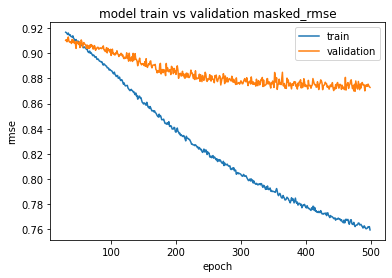

In [ ]:
show_rmse(hist_AutoRec_SElu_SElu_DR_avg, 30)

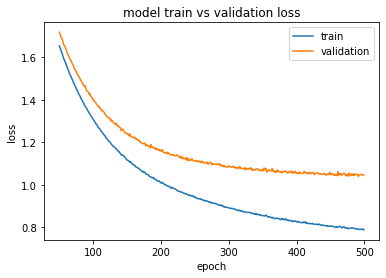

In [ ]:
show_error(hist_AutoRec_SElu_SElu_DR_avg, 50)

In [ ]:
test_result_hist_AutoRec_SElu_SElu_DR_avg = AutoRec_SElu_SElu_DR_avg.evaluate(users_items_matrix_train_average, users_items_matrix_test.astype(float))

189/189 [==============================] - 1s 3ms/step - loss: 1.0450 - masked_rmse_clip: 0.8759


In [ ]:
predict_Autorec_SElu_SElu_DR_avg = AutoRec_SElu_SElu_DR_avg.predict(users_items_matrix_train_zero)

In [ ]:
predict_Autorec_SElu_SElu_DR_avg

array([[ 2.9275944 ,  0.36615705,  0.37230974, ...,  0.33083522,
         0.08971754,  0.16283353],
       [ 0.53579986,  0.40688843,  0.12782715, ...,  0.3117531 ,
         0.33730873,  0.49859372],
       [ 1.3208508 , -0.25809783, -0.17699628, ...,  0.12767191,
         0.19802764,  0.21970993],
       ...,
       [ 0.52598846, -0.16520913, -0.00497307, ...,  0.05568331,
         0.08827185,  0.13064907],
       [ 1.428129  , -0.64036715, -0.9674675 , ...,  0.36926386,
         0.28638607,  0.2947542 ],
       [ 0.87160116, -0.84908146, -1.4578906 , ...,  0.9718855 ,
         0.71989584,  0.13319975]], dtype=float32)

## Using best AutoEncoder model give movie recommendation to user id 2000

In [68]:
movies = pd.read_csv('ml1m_movies.csv',sep=',', encoding='latin-1', 
                      usecols=['movie_emb_id', 'title', 'genre'])

In [ ]:
my_predict=pd.DataFrame(predict_Autorec_SElu_SElu_DR_avg)
Deep_AE_recommend_topx(2000,my_predict,movies,20)

,movie_emb_id,title,genre
109,110,Taxi Driver (1976),Drama|Thriller
847,857,"Godfather, The (1972)",Action|Crime|Drama
956,967,Night of the Living Dead (1968),Horror|Sci-Fi
1188,1205,"Clockwork Orange, A (1971)",Sci-Fi
1627,1672,Boogie Nights (1997),Drama
1928,1996,"Exorcist, The (1973)",Horror
2007,2075,Blue Velvet (1986),Drama|Mystery
2091,2159,Rosemary's Baby (1968),Horror|Thriller
2614,2682,Austin Powers: The Spy Who Shagged Me (1999),Comedy
2625,2693,Big Daddy (1999),Comedy


In [ ]:
save_model("AutoEncoder-SeLu-SeLu-DR-avg",AutoRec_SElu_SElu_DR_avg)

Saved model to disk


# Deep AutoEncoder

In [ ]:
def Deep_AE_model(X, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, side_infor_size=0):
    '''
    Build Deep AE for CF
        INPUT: 
            X: user or item matrix
            layers: List, each element is the number of neuron for a layer
            reg: L2 regularization parameter
            activation: activation function for all dense layer except the last
            last_activation: activation function for the last dense layer
            dropout: dropout rate
            regularizer_encode: regularizer for encoder
            regularizer_decode: regularizer for decoder
            side_infor_size: size of the one hot encoding side information
        OUTPUT:
            Keras model
    '''
    # Input
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    # Encoder
    # -----------------------------
    k = int(len(layers)/2)
    i = 0
    for l in layers[:k]:
      x = Dense(l, activation=activation,
                      name='EncLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_encode))(x)
      i = i+1
    # Hidden layer
    # -----------------------------
    x = Dense(layers[k], activation=activation, 
                                name='LatentSpace', kernel_regularizer=regularizers.l2(regularizer_encode))(x)
    
    # Dropout
    x = Dropout(rate = dropout)(x)
    
    # Decoder
    # -----------------------------
    for l in layers[k+1:]:
      i = i-1
      x = Dense(l, activation=activation, 
                      name='DecLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_decode))(x)
      
    # Output

    output_layer = Dense(X.shape[1]-side_infor_size, activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(regularizer_decode))(x)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)

    return model

## Build model with structure [512, 256, 512] and Default rating = average

In [ ]:
layers = [512, 256, 512]
dropout = 0.8
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

In [ ]:
Deep_AE_512_256_512_DR_avg = Deep_AE_model(users_items_matrix_train_zero, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE_512_256_512_DR_avg.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE_512_256_512_DR_avg.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 EncLayer0 (Dense)           (None, 512)               2023936   
                                                                 
 LatentSpace (Dense)         (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 DecLayer0 (Dense)           (None, 512)               131584    
                                                                 
 UserScorePred (Dense)       (None, 3952)              2027376   
                                                                 
Total params: 4,314,224
Trainable params: 4,314,224
Non-tra

In [ ]:
hist_Deep_AE_512_256_512_DR_avg = Deep_AE_512_256_512_DR_avg.fit(x=users_items_matrix_train_average.astype(float), y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_average.astype(float), users_items_matrix_validate.astype(float)], verbose=2)

Epoch 1/500
24/24 - 1s - loss: 13.9808 - masked_rmse_clip: 2.3595 - val_loss: 8.5980 - val_masked_rmse_clip: 2.1050 - 1s/epoch - 54ms/step
Epoch 2/500
24/24 - 0s - loss: 7.8915 - masked_rmse_clip: 1.8881 - val_loss: 4.8991 - val_masked_rmse_clip: 1.4802 - 322ms/epoch - 13ms/step
Epoch 3/500
24/24 - 0s - loss: 5.4314 - masked_rmse_clip: 1.5666 - val_loss: 3.6948 - val_masked_rmse_clip: 1.1106 - 329ms/epoch - 14ms/step
Epoch 4/500
24/24 - 0s - loss: 4.6525 - masked_rmse_clip: 1.4160 - val_loss: 3.3185 - val_masked_rmse_clip: 0.9606 - 314ms/epoch - 13ms/step
Epoch 5/500
24/24 - 0s - loss: 4.3418 - masked_rmse_clip: 1.3422 - val_loss: 3.3315 - val_masked_rmse_clip: 0.9947 - 308ms/epoch - 13ms/step
Epoch 6/500
24/24 - 0s - loss: 4.1627 - masked_rmse_clip: 1.3047 - val_loss: 3.2096 - val_masked_rmse_clip: 0.9479 - 325ms/epoch - 14ms/step
Epoch 7/500
24/24 - 0s - loss: 4.0518 - masked_rmse_clip: 1.2784 - val_loss: 3.1322 - val_masked_rmse_clip: 0.9209 - 312ms/epoch - 13ms/step
Epoch 8/500
24/

In [ ]:
print(sorted(hist_Deep_AE_512_256_512_DR_avg.history['val_masked_rmse_clip']))

[0.8737262487411499, 0.8742234110832214, 0.8749071955680847, 0.8749086260795593, 0.8749373555183411, 0.8750734329223633, 0.8750825524330139, 0.8751043677330017, 0.8751081824302673, 0.87518310546875, 0.8753809332847595, 0.875405490398407, 0.8755933046340942, 0.8757095336914062, 0.8758261203765869, 0.875878095626831, 0.8759105205535889, 0.8759322762489319, 0.8760344982147217, 0.876181960105896, 0.8761914968490601, 0.8761952519416809, 0.8761976361274719, 0.876215934753418, 0.8762508034706116, 0.876286506652832, 0.8763137459754944, 0.8763756155967712, 0.8764198422431946, 0.8764294385910034, 0.8764952421188354, 0.8765415549278259, 0.8767140507698059, 0.8767206072807312, 0.876750111579895, 0.8768655061721802, 0.8768808245658875, 0.8769397139549255, 0.877023458480835, 0.8770241141319275, 0.8770902156829834, 0.8771467208862305, 0.8772612810134888, 0.877327024936676, 0.8773348331451416, 0.87749183177948, 0.8775275945663452, 0.877569854259491, 0.8776506781578064, 0.8777287006378174, 0.8777332305

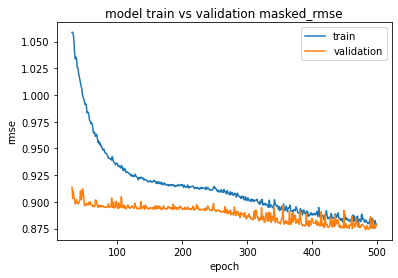

In [ ]:
show_rmse(hist_Deep_AE_512_256_512_DR_avg, 30)

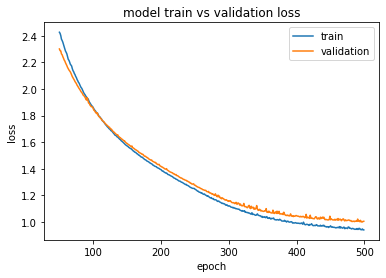

In [ ]:
show_error(hist_Deep_AE_512_256_512_DR_avg, 50)

In [ ]:
test_result_hist_Deep_AE_512_256_512_DR_avg = Deep_AE_512_256_512_DR_avg.evaluate(users_items_matrix_train_average, users_items_matrix_test.astype(float))

189/189 [==============================] - 1s 4ms/step - loss: 1.0038 - masked_rmse_clip: 0.8803


## Build model with structure [512, 256, 512] and Default rating = 0

In [ ]:
layers = [512, 256, 512]
dropout = 0.8
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

In [ ]:
Deep_AE_512_256_512_DR_0 = Deep_AE_model(users_items_matrix_train_zero, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE_512_256_512_DR_0.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE_512_256_512_DR_0.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 EncLayer0 (Dense)           (None, 512)               2023936   
                                                                 
 LatentSpace (Dense)         (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 DecLayer0 (Dense)           (None, 512)               131584    
                                                                 
 UserScorePred (Dense)       (None, 3952)              2027376   
                                                                 
Total params: 4,314,224
Trainable params: 4,314,224
Non-tra

In [ ]:
hist_Deep_AE_512_256_512_DR_0 = Deep_AE_512_256_512_DR_0.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate.astype(float)], verbose=2)

Epoch 1/500
24/24 - 1s - loss: 16.6166 - masked_rmse_clip: 2.8061 - val_loss: 12.9396 - val_masked_rmse_clip: 2.6945 - 1s/epoch - 56ms/step
Epoch 2/500
24/24 - 0s - loss: 10.3984 - masked_rmse_clip: 2.2700 - val_loss: 6.0016 - val_masked_rmse_clip: 1.7003 - 414ms/epoch - 17ms/step
Epoch 3/500
24/24 - 0s - loss: 6.1643 - masked_rmse_clip: 1.7002 - val_loss: 4.1154 - val_masked_rmse_clip: 1.2360 - 407ms/epoch - 17ms/step
Epoch 4/500
24/24 - 0s - loss: 4.8584 - masked_rmse_clip: 1.4474 - val_loss: 3.6406 - val_masked_rmse_clip: 1.0941 - 405ms/epoch - 17ms/step
Epoch 5/500
24/24 - 1s - loss: 4.5193 - masked_rmse_clip: 1.3786 - val_loss: 3.4557 - val_masked_rmse_clip: 1.0446 - 503ms/epoch - 21ms/step
Epoch 6/500
24/24 - 1s - loss: 4.3288 - masked_rmse_clip: 1.3478 - val_loss: 3.3466 - val_masked_rmse_clip: 1.0198 - 629ms/epoch - 26ms/step
Epoch 7/500
24/24 - 1s - loss: 4.1683 - masked_rmse_clip: 1.3154 - val_loss: 3.2730 - val_masked_rmse_clip: 1.0093 - 570ms/epoch - 24ms/step
Epoch 8/500
2

In [ ]:
print(sorted(hist_Deep_AE_512_256_512_DR_0.history['val_masked_rmse_clip']))

[0.850193440914154, 0.8503061532974243, 0.8503527641296387, 0.8504382371902466, 0.8505603075027466, 0.8506101369857788, 0.8506481051445007, 0.8506599068641663, 0.8506692051887512, 0.8507131934165955, 0.8507654666900635, 0.8507843017578125, 0.8507859110832214, 0.8507871627807617, 0.8508123159408569, 0.8508305549621582, 0.850862443447113, 0.850867509841919, 0.850872814655304, 0.8509043455123901, 0.8509290814399719, 0.8509309887886047, 0.850933849811554, 0.850947916507721, 0.8509737849235535, 0.8509825468063354, 0.8510279655456543, 0.851055920124054, 0.8510619401931763, 0.8510937690734863, 0.8510998487472534, 0.8511114120483398, 0.8511191606521606, 0.85112464427948, 0.8511664867401123, 0.8511765003204346, 0.8511830568313599, 0.8511908650398254, 0.8512113094329834, 0.8512210249900818, 0.8512224555015564, 0.8512391448020935, 0.8512512445449829, 0.8512557148933411, 0.8512591123580933, 0.8512645363807678, 0.8512698411941528, 0.8512771129608154, 0.8512784242630005, 0.8513022065162659, 0.851317

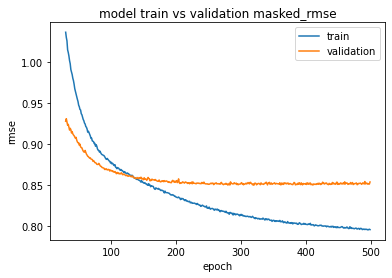

In [ ]:
show_rmse(hist_Deep_AE_512_256_512_DR_0, 30)

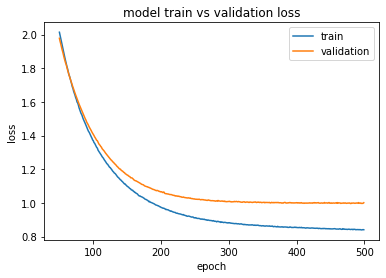

In [ ]:
show_error(hist_Deep_AE_512_256_512_DR_0, 50)

In [ ]:
test_result_hist_Deep_AE_512_256_512_DR_0 = Deep_AE_512_256_512_DR_0.evaluate(users_items_matrix_train_zero, users_items_matrix_test.astype(float))

189/189 [==============================] - 1s 3ms/step - loss: 0.9969 - masked_rmse_clip: 0.8535


## Build model with structure [256, 512, 256] and Default rating = average

In [ ]:
layers = [256, 512, 256]
dropout = 0.8
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

In [ ]:
Deep_AE_256_512_256_DR_avg = Deep_AE_model(users_items_matrix_train_zero, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE_256_512_256_DR_avg.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE_256_512_256_DR_avg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 EncLayer0 (Dense)           (None, 256)               1011968   
                                                                 
 LatentSpace (Dense)         (None, 512)               131584    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 DecLayer0 (Dense)           (None, 256)               131328    
                                                                 
 UserScorePred (Dense)       (None, 3952)              1015664   
                                                                 
Total params: 2,290,544
Trainable params: 2,290,544
Non-train

In [ ]:
hist_Deep_AE_256_512_256_DR_avg = Deep_AE_256_512_256_DR_avg.fit(x=users_items_matrix_train_average.astype(float), y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_average.astype(float), users_items_matrix_validate.astype(float)], verbose=2)

Epoch 1/500
24/24 - 5s - loss: 13.5000 - masked_rmse_clip: 2.3879 - val_loss: 8.5862 - val_masked_rmse_clip: 2.1202 - 5s/epoch - 210ms/step
Epoch 2/500
24/24 - 4s - loss: 7.5131 - masked_rmse_clip: 1.9243 - val_loss: 4.1303 - val_masked_rmse_clip: 1.4283 - 4s/epoch - 150ms/step
Epoch 3/500
24/24 - 4s - loss: 4.5536 - masked_rmse_clip: 1.5439 - val_loss: 2.8620 - val_masked_rmse_clip: 1.0685 - 4s/epoch - 148ms/step
Epoch 4/500
24/24 - 3s - loss: 3.5987 - masked_rmse_clip: 1.3434 - val_loss: 2.5891 - val_masked_rmse_clip: 0.9648 - 3s/epoch - 139ms/step
Epoch 5/500
24/24 - 3s - loss: 3.2679 - masked_rmse_clip: 1.2539 - val_loss: 2.5278 - val_masked_rmse_clip: 0.9479 - 3s/epoch - 139ms/step
Epoch 6/500
24/24 - 3s - loss: 3.1039 - masked_rmse_clip: 1.2067 - val_loss: 2.4597 - val_masked_rmse_clip: 0.9197 - 3s/epoch - 135ms/step
Epoch 7/500
24/24 - 3s - loss: 2.9840 - masked_rmse_clip: 1.1692 - val_loss: 2.4477 - val_masked_rmse_clip: 0.9243 - 3s/epoch - 142ms/step
Epoch 8/500
24/24 - 3s - l

In [ ]:
print(sorted(hist_Deep_AE_256_512_256_DR_avg.history['val_masked_rmse_clip']))

[0.8724572062492371, 0.8732324242591858, 0.8735020756721497, 0.8735172152519226, 0.8736574053764343, 0.8737223744392395, 0.8738215565681458, 0.8739165663719177, 0.8739927411079407, 0.8740143179893494, 0.8741005063056946, 0.874337911605835, 0.8745450973510742, 0.8745629787445068, 0.8745840787887573, 0.8747420310974121, 0.8747628331184387, 0.8748008012771606, 0.8749322295188904, 0.8749627470970154, 0.874985933303833, 0.8749915361404419, 0.875004768371582, 0.8753973245620728, 0.8754220604896545, 0.8754305839538574, 0.875487744808197, 0.8755273222923279, 0.8756434321403503, 0.8756920695304871, 0.8759354948997498, 0.875942051410675, 0.8759474754333496, 0.8759751319885254, 0.8760100603103638, 0.8760759830474854, 0.8760966658592224, 0.876314103603363, 0.8763146996498108, 0.8763246536254883, 0.8763250112533569, 0.8765132427215576, 0.8765736818313599, 0.876575767993927, 0.8766001462936401, 0.8766680955886841, 0.8766708970069885, 0.8767063021659851, 0.8767135739326477, 0.8767513632774353, 0.8767

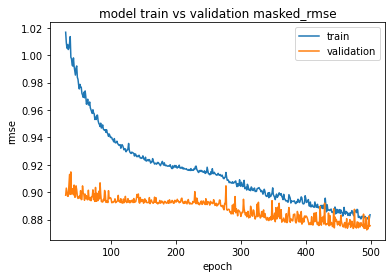

In [ ]:
show_rmse(hist_Deep_AE_256_512_256_DR_avg, 30)

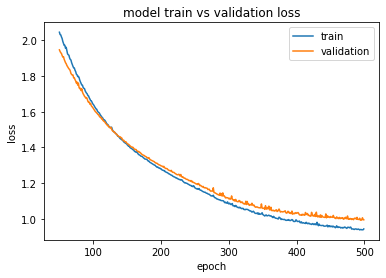

In [ ]:
show_error(hist_Deep_AE_256_512_256_DR_avg, 50)

In [ ]:
test_result_Deep_AE_256_512_256_DR_avg = Deep_AE_256_512_256_DR_avg.evaluate(users_items_matrix_train_average, users_items_matrix_test.astype(float))

189/189 [==============================] - 3s 14ms/step - loss: 0.9945 - masked_rmse_clip: 0.8780


## Build model with structure [256, 512, 256] and Default rating = 0

In [ ]:
layers = [256, 512, 256]
dropout = 0.8
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

In [ ]:
Deep_AE_256_512_256_DR_0 = Deep_AE_model(users_items_matrix_train_zero, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE_256_512_256_DR_0.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE_256_512_256_DR_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 EncLayer0 (Dense)           (None, 256)               1011968   
                                                                 
 LatentSpace (Dense)         (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 DecLayer0 (Dense)           (None, 256)               131328    
                                                                 
 UserScorePred (Dense)       (None, 3952)              1015664   
                                                                 
Total params: 2,290,544
Trainable params: 2,290,544
Non-tra

In [ ]:
hist_Deep_AE_256_512_256_DR_0 = Deep_AE_256_512_256_DR_0.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate.astype(float)], verbose=2)


Epoch 1/500
24/24 - 4s - loss: 16.2914 - masked_rmse_clip: 2.8601 - val_loss: 13.9933 - val_masked_rmse_clip: 2.8147 - 4s/epoch - 178ms/step
Epoch 2/500
24/24 - 4s - loss: 10.9352 - masked_rmse_clip: 2.4662 - val_loss: 6.5174 - val_masked_rmse_clip: 1.8998 - 4s/epoch - 148ms/step
Epoch 3/500
24/24 - 4s - loss: 6.0353 - masked_rmse_clip: 1.7970 - val_loss: 3.8601 - val_masked_rmse_clip: 1.3781 - 4s/epoch - 153ms/step
Epoch 4/500
24/24 - 3s - loss: 4.2193 - masked_rmse_clip: 1.4788 - val_loss: 3.0936 - val_masked_rmse_clip: 1.1586 - 3s/epoch - 143ms/step
Epoch 5/500
24/24 - 3s - loss: 3.6492 - masked_rmse_clip: 1.3487 - val_loss: 2.8569 - val_masked_rmse_clip: 1.0863 - 3s/epoch - 143ms/step
Epoch 6/500
24/24 - 3s - loss: 3.4709 - masked_rmse_clip: 1.3088 - val_loss: 2.7376 - val_masked_rmse_clip: 1.0528 - 3s/epoch - 144ms/step
Epoch 7/500
24/24 - 4s - loss: 3.3194 - masked_rmse_clip: 1.2784 - val_loss: 2.6517 - val_masked_rmse_clip: 1.0277 - 4s/epoch - 165ms/step
Epoch 8/500
24/24 - 3s -

In [ ]:
print(sorted(hist_Deep_AE_256_512_256_DR_0.history['val_masked_rmse_clip']))

[0.8499795198440552, 0.8500141501426697, 0.8501862287521362, 0.8502885103225708, 0.8503384590148926, 0.8503606915473938, 0.850431501865387, 0.8505385518074036, 0.850622296333313, 0.8506617546081543, 0.8506633043289185, 0.850747287273407, 0.8507639765739441, 0.8508208394050598, 0.8508337140083313, 0.8508402109146118, 0.8508660793304443, 0.850988507270813, 0.8510542511940002, 0.8511754870414734, 0.8511951565742493, 0.8512356877326965, 0.8512389063835144, 0.8512486815452576, 0.8512586355209351, 0.8512915968894958, 0.8513093590736389, 0.851333737373352, 0.8513496518135071, 0.8513625860214233, 0.8513755798339844, 0.8513793349266052, 0.851402759552002, 0.8514038324356079, 0.8514070510864258, 0.8514230251312256, 0.8514326810836792, 0.8514379858970642, 0.8514645099639893, 0.85149085521698, 0.8515164256095886, 0.8515298962593079, 0.8515332341194153, 0.8515599966049194, 0.8515958786010742, 0.8516085147857666, 0.8516280055046082, 0.8516359925270081, 0.8516511917114258, 0.8516640663146973, 0.85166

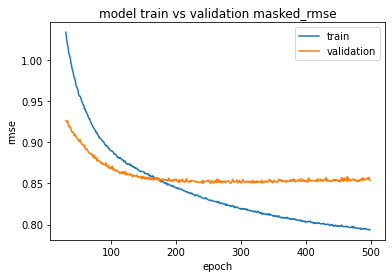

In [ ]:
show_rmse(hist_Deep_AE_256_512_256_DR_0, 30)

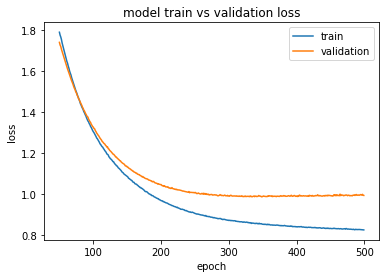

In [ ]:
show_error(hist_Deep_AE_256_512_256_DR_0, 50)

In [ ]:
test_result_Deep_AE_256_512_256_DR_0 = Deep_AE_256_512_256_DR_0.evaluate(users_items_matrix_train_zero, users_items_matrix_test.astype(float))

189/189 [==============================] - 3s 15ms/step - loss: 0.9899 - masked_rmse_clip: 0.8548


In [69]:
predict_Deep_AE_256_512_256_DR_0 = Deep_AE_256_512_256_DR_0.predict(users_items_matrix_train_zero)
predict_Deep_AE_256_512_256_DR_0

array([[4.459125 , 3.7307808, 3.3038645, ..., 3.498673 , 3.7505393,
        4.1155157],
       [4.275155 , 3.3773592, 3.0263393, ..., 3.4899902, 3.6975007,
        4.042038 ],
       [3.7528489, 2.9794805, 4.062473 , ..., 2.4221387, 2.7671523,
        3.4059865],
       ...,
       [3.541235 , 2.8622715, 2.972657 , ..., 2.8762374, 3.255992 ,
        3.598405 ],
       [3.6083417, 3.088525 , 2.9397488, ..., 3.4552393, 3.7206583,
        3.8638754],
       [3.3028421, 1.9486506, 1.6503768, ..., 3.5960906, 3.9768784,
        3.1821117]], dtype=float32)

## Build model with structure [512, 256, 128, 256, 512] and Default rating = average

In [35]:
layers = [512, 256, 128, 256, 512]
dropout = 0.8
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

In [36]:
Deep_AE_512_256_128_256_512_DR_avg = Deep_AE_model(users_items_matrix_train_zero, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE_512_256_128_256_512_DR_avg.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE_512_256_128_256_512_DR_avg.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 EncLayer0 (Dense)           (None, 512)               2023936   
                                                                 
 EncLayer1 (Dense)           (None, 256)               131328    
                                                                 
 LatentSpace (Dense)         (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 DecLayer1 (Dense)           (None, 256)               33024     
                                                                 
 DecLayer0 (Dense)           (None, 512)               1315

In [37]:
hist_Deep_AE_512_256_128_256_512_DR_avg = Deep_AE_512_256_128_256_512_DR_avg.fit(x=users_items_matrix_train_average.astype(float), y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_average.astype(float), users_items_matrix_validate.astype(float)], verbose=2)

Epoch 1/500
24/24 - 7s - loss: 14.0782 - masked_rmse_clip: 2.3901 - val_loss: 8.6566 - val_masked_rmse_clip: 2.0799 - 7s/epoch - 276ms/step
Epoch 2/500
24/24 - 5s - loss: 7.2426 - masked_rmse_clip: 1.7802 - val_loss: 4.8210 - val_masked_rmse_clip: 1.3767 - 5s/epoch - 217ms/step
Epoch 3/500
24/24 - 5s - loss: 5.0972 - masked_rmse_clip: 1.4291 - val_loss: 4.3907 - val_masked_rmse_clip: 1.2706 - 5s/epoch - 227ms/step
Epoch 4/500
24/24 - 5s - loss: 4.5224 - masked_rmse_clip: 1.2949 - val_loss: 3.7036 - val_masked_rmse_clip: 1.0011 - 5s/epoch - 225ms/step
Epoch 5/500
24/24 - 6s - loss: 4.2974 - masked_rmse_clip: 1.2368 - val_loss: 3.7340 - val_masked_rmse_clip: 1.0406 - 6s/epoch - 235ms/step
Epoch 6/500
24/24 - 6s - loss: 4.1590 - masked_rmse_clip: 1.2090 - val_loss: 3.4799 - val_masked_rmse_clip: 0.9265 - 6s/epoch - 231ms/step
Epoch 7/500
24/24 - 6s - loss: 4.0380 - masked_rmse_clip: 1.1813 - val_loss: 3.4499 - val_masked_rmse_clip: 0.9373 - 6s/epoch - 235ms/step
Epoch 8/500
24/24 - 5s - l

[0.8941652774810791, 0.8946252465248108, 0.8947005271911621, 0.8948768377304077, 0.895013153553009, 0.8950667977333069, 0.8951576948165894, 0.8952933549880981, 0.8953589200973511, 0.8953902125358582, 0.8954904079437256, 0.8955731987953186, 0.8955930471420288, 0.8956015706062317, 0.8956062197685242, 0.895696759223938, 0.8957035541534424, 0.8958019018173218, 0.895858645439148, 0.8958672881126404, 0.8958737850189209, 0.8958872556686401, 0.8959470987319946, 0.895958423614502, 0.8960139751434326, 0.8960369229316711, 0.8961594104766846, 0.8961771726608276, 0.8961785435676575, 0.8962947130203247, 0.8963651061058044, 0.8963857293128967, 0.8964077234268188, 0.8964237570762634, 0.8966760635375977, 0.8966942429542542, 0.8968181014060974, 0.8968321681022644, 0.8968651294708252, 0.8969425559043884, 0.8969689607620239, 0.8970963358879089, 0.8971533179283142, 0.8971598148345947, 0.8972136974334717, 0.8972320556640625, 0.8973404765129089, 0.8975090384483337, 0.8976190686225891, 0.8977218866348267, 0.8

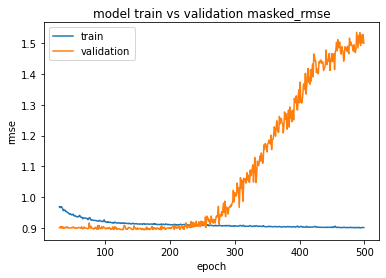

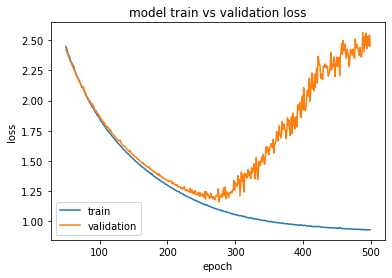

189/189 [==============================] - 4s 22ms/step - loss: 2.4519 - masked_rmse_clip: 1.5033


In [38]:
print(sorted(hist_Deep_AE_512_256_128_256_512_DR_avg.history['val_masked_rmse_clip']))
show_rmse(hist_Deep_AE_512_256_128_256_512_DR_avg, 30)
show_error(hist_Deep_AE_512_256_128_256_512_DR_avg, 50)
test_result_Deep_AE_512_256_128_256_512_DR_avg = Deep_AE_512_256_128_256_512_DR_avg.evaluate(users_items_matrix_train_average, users_items_matrix_test.astype(float))

## Build model with structure [512, 256, 128, 256, 512] and Default rating = 0

In [40]:
layers = [512, 256, 128, 256, 512]
dropout = 0.8
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

In [41]:
Deep_AE_512_256_128_256_512_DR_0 = Deep_AE_model(users_items_matrix_train_zero, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE_512_256_128_256_512_DR_0.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE_512_256_128_256_512_DR_0.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 EncLayer0 (Dense)           (None, 512)               2023936   
                                                                 
 EncLayer1 (Dense)           (None, 256)               131328    
                                                                 
 LatentSpace (Dense)         (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 DecLayer1 (Dense)           (None, 256)               33024     
                                                                 
 DecLayer0 (Dense)           (None, 512)               1315

In [42]:
hist_Deep_AE_512_256_128_256_512_DR_0 = Deep_AE_512_256_128_256_512_DR_0.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate.astype(float)], verbose=2)

Epoch 1/500
24/24 - 7s - loss: 16.0899 - masked_rmse_clip: 2.7679 - val_loss: 10.4232 - val_masked_rmse_clip: 2.3932 - 7s/epoch - 272ms/step
Epoch 2/500
24/24 - 5s - loss: 8.3676 - masked_rmse_clip: 1.9516 - val_loss: 4.8630 - val_masked_rmse_clip: 1.3611 - 5s/epoch - 220ms/step
Epoch 3/500
24/24 - 5s - loss: 5.1940 - masked_rmse_clip: 1.4422 - val_loss: 3.9045 - val_masked_rmse_clip: 1.0519 - 5s/epoch - 218ms/step
Epoch 4/500
24/24 - 5s - loss: 4.5643 - masked_rmse_clip: 1.3003 - val_loss: 3.7030 - val_masked_rmse_clip: 0.9927 - 5s/epoch - 227ms/step
Epoch 5/500
24/24 - 5s - loss: 4.3297 - masked_rmse_clip: 1.2502 - val_loss: 3.6138 - val_masked_rmse_clip: 0.9759 - 5s/epoch - 218ms/step
Epoch 6/500
24/24 - 5s - loss: 4.1779 - masked_rmse_clip: 1.2211 - val_loss: 3.5463 - val_masked_rmse_clip: 0.9679 - 5s/epoch - 220ms/step
Epoch 7/500
24/24 - 5s - loss: 4.0436 - masked_rmse_clip: 1.1948 - val_loss: 3.4906 - val_masked_rmse_clip: 0.9606 - 5s/epoch - 229ms/step
Epoch 8/500
24/24 - 5s - 

[0.8531518578529358, 0.8533741235733032, 0.8534188866615295, 0.853933572769165, 0.8539499640464783, 0.8539873361587524, 0.854049801826477, 0.8540657758712769, 0.8541190028190613, 0.8541244268417358, 0.854125440120697, 0.8542002439498901, 0.8542487025260925, 0.8542554974555969, 0.854259192943573, 0.8542906641960144, 0.8542952537536621, 0.8543116450309753, 0.8543691635131836, 0.8544180393218994, 0.8545700311660767, 0.8546103239059448, 0.8546270132064819, 0.8546392321586609, 0.8546451926231384, 0.8546541333198547, 0.8546692132949829, 0.8546891808509827, 0.8547059297561646, 0.8547196984291077, 0.8547295928001404, 0.854745626449585, 0.8547632694244385, 0.8547770977020264, 0.8547942042350769, 0.8548848628997803, 0.8549294471740723, 0.8549889326095581, 0.8550113439559937, 0.8550242185592651, 0.8550794124603271, 0.855084240436554, 0.8551132678985596, 0.8551381230354309, 0.8551502227783203, 0.8551521897315979, 0.8551772236824036, 0.8551772236824036, 0.855181872844696, 0.8551991581916809, 0.8552

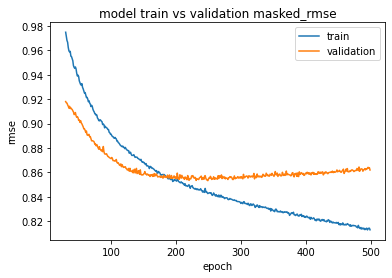

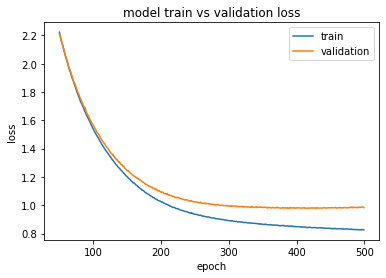

189/189 [==============================] - 4s 19ms/step - loss: 0.9813 - masked_rmse_clip: 0.8648


In [43]:
print(sorted(hist_Deep_AE_512_256_128_256_512_DR_0.history['val_masked_rmse_clip']))
show_rmse(hist_Deep_AE_512_256_128_256_512_DR_0, 30)
show_error(hist_Deep_AE_512_256_128_256_512_DR_0, 50)
test_result_Deep_AE_512_256_128_256_512_DR_0 = Deep_AE_512_256_128_256_512_DR_0.evaluate(users_items_matrix_train_zero, users_items_matrix_test.astype(float))

## Build model with structure [128, 256, 512, 256, 128] and Default rating = average

In [44]:
layers = [128, 256, 512, 256, 128]
dropout = 0.8
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

In [45]:
Deep_AE_128_256_512_256_128_DR_avg = Deep_AE_model(users_items_matrix_train_zero, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE_128_256_512_256_128_DR_avg.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE_128_256_512_256_128_DR_avg.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 EncLayer0 (Dense)           (None, 128)               505984    
                                                                 
 EncLayer1 (Dense)           (None, 256)               33024     
                                                                 
 LatentSpace (Dense)         (None, 512)               131584    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 DecLayer1 (Dense)           (None, 256)               131328    
                                                                 
 DecLayer0 (Dense)           (None, 128)               3289

In [46]:
hist_Deep_AE_128_256_512_256_128_DR_avg = Deep_AE_128_256_512_256_128_DR_avg.fit(x=users_items_matrix_train_average.astype(float), y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_average.astype(float), users_items_matrix_validate.astype(float)], verbose=2)

Epoch 1/500
24/24 - 3s - loss: 13.7530 - masked_rmse_clip: 2.4922 - val_loss: 9.5445 - val_masked_rmse_clip: 2.1917 - 3s/epoch - 143ms/step
Epoch 2/500
24/24 - 2s - loss: 7.6763 - masked_rmse_clip: 1.9430 - val_loss: 4.7357 - val_masked_rmse_clip: 1.5009 - 2s/epoch - 94ms/step
Epoch 3/500
24/24 - 2s - loss: 4.3283 - masked_rmse_clip: 1.4814 - val_loss: 3.0107 - val_masked_rmse_clip: 1.0963 - 2s/epoch - 93ms/step
Epoch 4/500
24/24 - 2s - loss: 3.1988 - masked_rmse_clip: 1.2296 - val_loss: 2.5773 - val_masked_rmse_clip: 0.9662 - 2s/epoch - 95ms/step
Epoch 5/500
24/24 - 2s - loss: 2.8344 - masked_rmse_clip: 1.1275 - val_loss: 2.4299 - val_masked_rmse_clip: 0.9272 - 2s/epoch - 93ms/step
Epoch 6/500
24/24 - 2s - loss: 2.6798 - masked_rmse_clip: 1.0794 - val_loss: 2.4313 - val_masked_rmse_clip: 0.9469 - 2s/epoch - 94ms/step
Epoch 7/500
24/24 - 2s - loss: 2.5983 - masked_rmse_clip: 1.0560 - val_loss: 2.3384 - val_masked_rmse_clip: 0.9088 - 2s/epoch - 93ms/step
Epoch 8/500
24/24 - 2s - loss: 2

[0.8911489248275757, 0.8914592266082764, 0.8915255069732666, 0.891563892364502, 0.8916600346565247, 0.8916661739349365, 0.8916754722595215, 0.8916893005371094, 0.8917093873023987, 0.8917497396469116, 0.891822338104248, 0.8918330073356628, 0.8918364644050598, 0.8918461203575134, 0.8918520212173462, 0.8918602466583252, 0.89188152551651, 0.8918901681900024, 0.8919137716293335, 0.8919142484664917, 0.8919385671615601, 0.8919505476951599, 0.8919509053230286, 0.8919598460197449, 0.8919657468795776, 0.891969621181488, 0.891975998878479, 0.8919872045516968, 0.891989529132843, 0.8919904828071594, 0.8919922113418579, 0.8920074701309204, 0.892024040222168, 0.8920590281486511, 0.8920619487762451, 0.8920640349388123, 0.8920710682868958, 0.8920742273330688, 0.8920878767967224, 0.8920977115631104, 0.892103910446167, 0.8921061754226685, 0.892106831073761, 0.8921120166778564, 0.8921130299568176, 0.892118513584137, 0.8921216130256653, 0.8921463489532471, 0.892147958278656, 0.8921566009521484, 0.892165362

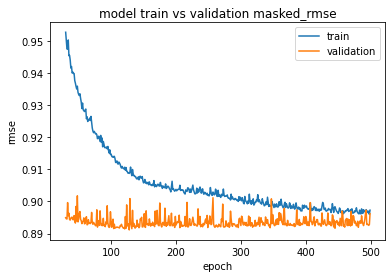

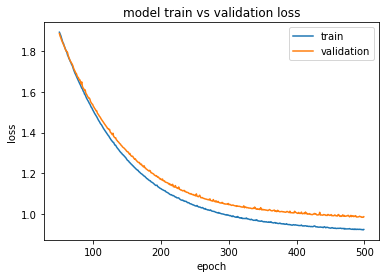

189/189 [==============================] - 2s 9ms/step - loss: 0.9786 - masked_rmse_clip: 0.8954


In [47]:
print(sorted(hist_Deep_AE_128_256_512_256_128_DR_avg.history['val_masked_rmse_clip']))
show_rmse(hist_Deep_AE_128_256_512_256_128_DR_avg, 30)
show_error(hist_Deep_AE_128_256_512_256_128_DR_avg, 50)
test_result_Deep_AE_128_256_512_256_128_DR_avg = Deep_AE_128_256_512_256_128_DR_avg.evaluate(users_items_matrix_train_average, users_items_matrix_test.astype(float))

## Build model with structure [128, 256, 512, 256, 128] and Default rating = 0

In [48]:
layers = [128, 256, 512, 256, 128]
dropout = 0.8
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

In [49]:
Deep_AE_128_256_512_256_128_DR_0 = Deep_AE_model(users_items_matrix_train_zero, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE_128_256_512_256_128_DR_0.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE_128_256_512_256_128_DR_0.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3952)]            0         
                                                                 
 EncLayer0 (Dense)           (None, 128)               505984    
                                                                 
 EncLayer1 (Dense)           (None, 256)               33024     
                                                                 
 LatentSpace (Dense)         (None, 512)               131584    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 DecLayer1 (Dense)           (None, 256)               131328    
                                                                 
 DecLayer0 (Dense)           (None, 128)               3289

In [50]:
hist_Deep_AE_128_256_512_256_128_DR_0 = Deep_AE_128_256_512_256_128_DR_0.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate.astype(float)], verbose=2)

Epoch 1/500
24/24 - 3s - loss: 16.3014 - masked_rmse_clip: 2.8885 - val_loss: 14.2930 - val_masked_rmse_clip: 2.8407 - 3s/epoch - 145ms/step
Epoch 2/500
24/24 - 2s - loss: 10.7300 - masked_rmse_clip: 2.4706 - val_loss: 6.1078 - val_masked_rmse_clip: 1.7623 - 2s/epoch - 98ms/step
Epoch 3/500
24/24 - 2s - loss: 4.8485 - masked_rmse_clip: 1.6032 - val_loss: 3.1479 - val_masked_rmse_clip: 1.1861 - 2s/epoch - 100ms/step
Epoch 4/500
24/24 - 2s - loss: 3.2652 - masked_rmse_clip: 1.2616 - val_loss: 2.6667 - val_masked_rmse_clip: 1.0286 - 2s/epoch - 98ms/step
Epoch 5/500
24/24 - 2s - loss: 2.9557 - masked_rmse_clip: 1.1749 - val_loss: 2.5505 - val_masked_rmse_clip: 0.9917 - 2s/epoch - 99ms/step
Epoch 6/500
24/24 - 2s - loss: 2.8396 - masked_rmse_clip: 1.1426 - val_loss: 2.4947 - val_masked_rmse_clip: 0.9747 - 2s/epoch - 99ms/step
Epoch 7/500
24/24 - 2s - loss: 2.7592 - masked_rmse_clip: 1.1194 - val_loss: 2.4556 - val_masked_rmse_clip: 0.9649 - 2s/epoch - 99ms/step
Epoch 8/500
24/24 - 2s - loss

[0.8584873080253601, 0.8585256934165955, 0.858636736869812, 0.858659565448761, 0.8586788177490234, 0.8586828112602234, 0.8587262630462646, 0.858744740486145, 0.8587483167648315, 0.8587678074836731, 0.8587852716445923, 0.8588026165962219, 0.8588113784790039, 0.8588716983795166, 0.8589117527008057, 0.8589252829551697, 0.8589338660240173, 0.8589348196983337, 0.8589500784873962, 0.8589788675308228, 0.8589959144592285, 0.8590213060379028, 0.8590248227119446, 0.859048068523407, 0.859102725982666, 0.8591089248657227, 0.8591110706329346, 0.8591272830963135, 0.8591387271881104, 0.8591467142105103, 0.8591471910476685, 0.8591513633728027, 0.8591709733009338, 0.8591862320899963, 0.859188973903656, 0.8592135310173035, 0.8592220544815063, 0.8592250347137451, 0.8592424392700195, 0.8592529296875, 0.8592568039894104, 0.8593107461929321, 0.8593785762786865, 0.8593935966491699, 0.8593975305557251, 0.8594315052032471, 0.8594322204589844, 0.8594525456428528, 0.8594598174095154, 0.8594602346420288, 0.859493

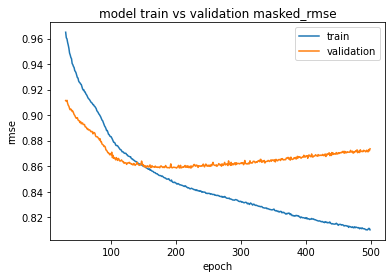

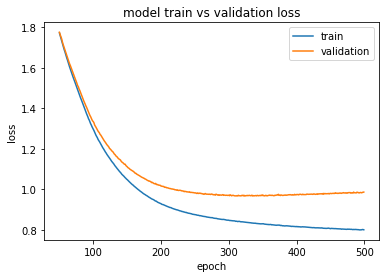

189/189 [==============================] - 2s 9ms/step - loss: 0.9947 - masked_rmse_clip: 0.8796


In [51]:
print(sorted(hist_Deep_AE_128_256_512_256_128_DR_0.history['val_masked_rmse_clip']))
show_rmse(hist_Deep_AE_128_256_512_256_128_DR_0, 30)
show_error(hist_Deep_AE_128_256_512_256_128_DR_0, 50)
test_result_Deep_AE_128_256_512_256_128_DR_0 = Deep_AE_128_256_512_256_128_DR_0.evaluate(users_items_matrix_train_zero, users_items_matrix_test.astype(float))

## Using best Deep AutoEncoder model give movie recommendation to user id 2000

In [70]:
my_predict=pd.DataFrame(predict_Deep_AE_256_512_256_DR_0)
Deep_AE_recommend_topx(2000,my_predict,movies,20)

,movie_emb_id,title,genre
585,588,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
589,592,"Silence of the Lambs, The (1991)",Drama|Thriller
801,810,"Bewegte Mann, Der (1994)",Comedy
847,857,"Godfather, The (1972)",Action|Crime|Drama
907,918,"Wizard of Oz, The (1939)",Adventure|Children's|Drama|Musical
941,952,It's a Wonderful Life (1946),Drama
977,988,Schlafes Bruder (Brother of Sleep) (1995),Drama
1162,1177,Paths of Glory (1957),Drama|War
1201,1218,Psycho (1960),Horror|Thriller
1214,1232,"Boat, The (Das Boot) (1981)",Action|Drama|War


In [71]:
save_model("DeepAE-SeLu-SeLu-256_512_256_DR_0",Deep_AE_256_512_256_DR_0)

Saved model to disk


# Hybrid Model

## Add information User

In [52]:
user_df = pd.read_csv('ml1m_users.csv',sep=',', encoding='latin-1', 
                      usecols=['user_emb_id', 'gender', 'age', 'occupation'])

user_df.head(5)

,user_emb_id,gender,age,occupation
0,0,F,1,10
1,1,M,56,16
2,2,M,25,15
3,3,M,45,7
4,4,M,25,20


In [53]:
# Transform side information to onehot encoding
user_df['age'] = preprocessing.LabelEncoder().fit(user_df['age']).transform(user_df['age'])
user_df['gender'] = preprocessing.LabelEncoder().fit(user_df['gender']).transform(user_df['gender'])
onehot_df = preprocessing.OneHotEncoder(handle_unknown='ignore', sparse=False).fit(user_df[['gender', 'age', 'occupation']]).transform(user_df[['gender', 'age', 'occupation']])

In [54]:
onehot_df.shape

(6040, 30)

In [55]:
user_items_user_info = np.concatenate((users_items_matrix_train_zero, onehot_df), axis=1)

In [56]:
user_items_user_info.shape

(6040, 3982)

In [61]:
layers = [256, 512, 256]
dropout = 0.8
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001
# Build model
Deep_AE_concate = Deep_AE_model(user_items_user_info, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, 30)
Deep_AE_concate.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE_concate.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserRating (InputLayer)     [(None, 3982)]            0         
                                                                 
 EncLayer0 (Dense)           (None, 256)               1019648   
                                                                 
 LatentSpace (Dense)         (None, 512)               131584    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 DecLayer0 (Dense)           (None, 256)               131328    
                                                                 
 UserScorePred (Dense)       (None, 3952)              1015664   
                                                                 
Total params: 2,298,224
Trainable params: 2,298,224
Non-tra

In [62]:
hist_Deep_AE_concate = Deep_AE_concate.fit(x=user_items_user_info, y=users_items_matrix_train_zero.astype(float),
                  epochs=500,
                  batch_size=256,
                  validation_data=[user_items_user_info, users_items_matrix_validate.astype(float)], verbose=2)

Epoch 1/500
24/24 - 8s - loss: 16.1435 - masked_rmse_clip: 2.8533 - val_loss: 13.5749 - val_masked_rmse_clip: 2.7938 - 8s/epoch - 327ms/step
Epoch 2/500
24/24 - 6s - loss: 10.5669 - masked_rmse_clip: 2.4272 - val_loss: 6.2877 - val_masked_rmse_clip: 1.8806 - 6s/epoch - 234ms/step
Epoch 3/500
24/24 - 6s - loss: 5.8818 - masked_rmse_clip: 1.7788 - val_loss: 3.7768 - val_masked_rmse_clip: 1.3581 - 6s/epoch - 261ms/step
Epoch 4/500
24/24 - 4s - loss: 4.1466 - masked_rmse_clip: 1.4659 - val_loss: 3.0330 - val_masked_rmse_clip: 1.1401 - 4s/epoch - 157ms/step
Epoch 5/500
24/24 - 4s - loss: 3.5980 - masked_rmse_clip: 1.3368 - val_loss: 2.8053 - val_masked_rmse_clip: 1.0679 - 4s/epoch - 152ms/step
Epoch 6/500
24/24 - 4s - loss: 3.3915 - masked_rmse_clip: 1.2920 - val_loss: 2.6962 - val_masked_rmse_clip: 1.0370 - 4s/epoch - 150ms/step
Epoch 7/500
24/24 - 3s - loss: 3.2863 - masked_rmse_clip: 1.2665 - val_loss: 2.6238 - val_masked_rmse_clip: 1.0176 - 3s/epoch - 135ms/step
Epoch 8/500
24/24 - 3s -

In [65]:
print(sorted(hist_Deep_AE_concate.history['val_masked_rmse_clip']))

[0.8498049974441528, 0.8499003052711487, 0.8500434160232544, 0.850080668926239, 0.850111186504364, 0.8501316905021667, 0.8501797914505005, 0.8502126336097717, 0.8502667546272278, 0.8502848148345947, 0.850296676158905, 0.8503747582435608, 0.8503772020339966, 0.850378155708313, 0.8503815531730652, 0.8503817319869995, 0.8504345417022705, 0.850435197353363, 0.8505038022994995, 0.8505255579948425, 0.8505364060401917, 0.850559413433075, 0.8506110906600952, 0.8506430387496948, 0.8506491780281067, 0.8506858348846436, 0.8507355451583862, 0.8507407307624817, 0.8507649898529053, 0.8507688045501709, 0.8507887721061707, 0.8508672118186951, 0.8508695960044861, 0.8508725166320801, 0.8508822917938232, 0.8508886098861694, 0.8508899211883545, 0.850894033908844, 0.8508999347686768, 0.8509129285812378, 0.8509228825569153, 0.8509261012077332, 0.8509342074394226, 0.8509600162506104, 0.850966215133667, 0.8509763479232788, 0.8510032296180725, 0.8510192632675171, 0.8510288596153259, 0.8510388731956482, 0.85104

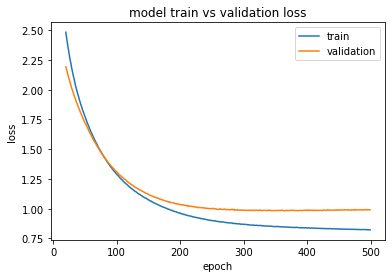

In [63]:
show_error(hist_Deep_AE_concate, 20)

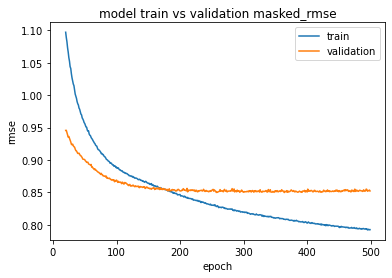

In [64]:
show_rmse(hist_Deep_AE_concate, 20)

In [ ]:
plot_model(Deep_AE_concate, to_file='model.png')

In [ ]:
test_result_deep_AE_concate = Deep_AE_concate.evaluate([users_items_matrix_train_zero, userIDs], users_items_matrix_test)

6040/6040 [==============================] - 1s 145us/sample - loss: 0.9974 - masked_rmse_clip: 0.8582


# Orther Model (Future Work) [Demo]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fda67b21630>,
      dtype=object)

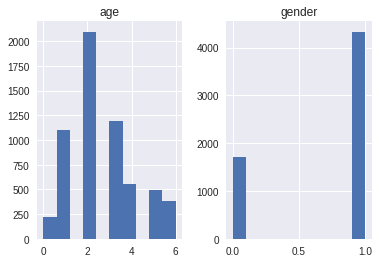

In [ ]:
user_df.hist(column=['age', 'gender'])

In [ ]:
#Concatenate the one hot encoding side information to the rating matrix
user_items_user_validate_info = np.concatenate((users_items_matrix_validate, onehot_df), axis=1)

In [ ]:
train_male_two = user_items_user_info[(user_items_user_info[:, 3953]==1) & (user_items_user_info[:, 3956]==1)]
validate_male_two = user_items_user_validate_info[(user_items_user_validate_info[:, 3953]==1) & (user_items_user_validate_info[:, 3956]==1)]

In [ ]:
validate_male_two.shape

(1538, 3982)

In [ ]:
 validate_male_two[:, :3952].shape

(1538, 3952)

In [ ]:
layers = [256, 512, 256]
dropout = 0.8
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.002
regularizer_decode = 0.002
# Build model
Deep_AE_concate = Deep_AE_model(train_male_two[:, :3952], layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE_concate.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE_concate.summary()
hist_Deep_AE_concate = Deep_AE_concate.fit(x=train_male_two[:, :3952], y=train_male_two[:, :3952],
                  epochs=500,
                  batch_size=256,
                  validation_data=[train_male_two[:, :3952], validate_male_two[:, :3952]], verbose=2)

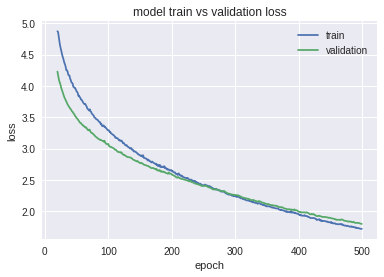

In [ ]:
show_error(hist_Deep_AE_concate, 20)

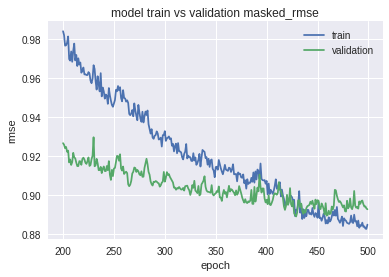

In [ ]:
show_rmse(hist_Deep_AE_concate, 200)